In [38]:
# Note this code is not optimized and might be very slow, for convergence purposes 5000 data points are 
# generated. If using ensambling this might be decreased while keeping reasonable performance.

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys, os
sys.path.append('../')
from data_handling import Container,load_data,Normalize,Denormalize
from plot_style.style_prab import load_preset,figsize
from plot_style.style_prab import colors as colors_preset
from train_ensemble import train, NN, Loss
from analysis.scan_model import median
load_preset(scale=1,font_path='../plot_style/font')

matplotlib preset loaded


In [2]:
#run generate_data

In [47]:
path = './toydata.h5'
inputs = ['x']  
outputs = ['y']

din = len(inputs)
dout = len(outputs)
norm = [[[0],[1]],
        [[0],[1]]]

config = {'path' : path, # Path to data
          'epochs': 200, # training epochs
          'estimators': 50, # networks in ensemble
          'inputs': inputs, # input labels
          'outputs': outputs, # output labels
          'samples': 5000, # number of samples form dataset
          'start_ind': 0, # start ind of samples from dataset 
          'batch_size': 1024, # batch size network
          'ratio': 0.9,
          'loss_fun':  Loss(), # loss function
          'model' : [NN(din+dout,din,hidden=4,layers=2),
                     NN(din,dout,hidden=4,layers=2)], # model
          'dest_path':'', # destination path of model
          'cuda' : False,
          'norm' : norm,
          'lr1' : 0.001,
          'lr2' : 0.001,
          'activation' : 'Tanh',
          'pre_training' : 100,
         }
ensemble_OD = train(config)



Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 3.82332 
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 3.90697 
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 3.64116 
Estimator: 003 | Epoch: 000 | Batch: 000 | Loss: 4.15261 
Estimator: 004 | Epoch: 000 | Batch: 000 | Loss: 3.98865 
Estimator: 005 | Epoch: 000 | Batch: 000 | Loss: 3.85649 
Estimator: 006 | Epoch: 000 | Batch: 000 | Loss: 3.86958 
Estimator: 007 | Epoch: 000 | Batch: 000 | Loss: 4.07261 
Estimator: 008 | Epoch: 000 | Batch: 000 | Loss: 4.01596 
Estimator: 009 | Epoch: 000 | Batch: 000 | Loss: 3.86274 
Estimator: 010 | Epoch: 000 | Batch: 000 | Loss: 3.94050 
Estimator: 011 | Epoch: 000 | Batch: 000 | Loss: 3.82780 
Estimator: 012 | Epoch: 000 | Batch: 000 | Loss: 3.84957 
Estimator: 013 | Epoch: 000 | Batch: 000 | Loss: 3.83496 
Estimator: 014 | Epoch: 000 | Batch: 000 | Loss: 3.91973 
Estimator: 015 | Epoch: 000 | Batch: 000 | Loss: 3.96589 
Estimator: 016 | Epoch: 000 | Batch: 000 | Loss: 3.95792 
Estimator: 017

Estimator: 042 | Epoch: 002 | Batch: 000 | Loss: 2.92274 
Estimator: 043 | Epoch: 002 | Batch: 000 | Loss: 2.75562 
Estimator: 044 | Epoch: 002 | Batch: 000 | Loss: 2.85470 
Estimator: 045 | Epoch: 002 | Batch: 000 | Loss: 2.73578 
Estimator: 046 | Epoch: 002 | Batch: 000 | Loss: 2.88741 
Estimator: 047 | Epoch: 002 | Batch: 000 | Loss: 2.88549 
Estimator: 048 | Epoch: 002 | Batch: 000 | Loss: 2.67848 
Estimator: 049 | Epoch: 002 | Batch: 000 | Loss: 2.77260 
Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 2.51200 
Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 2.40874 
Estimator: 002 | Epoch: 003 | Batch: 000 | Loss: 2.48971 
Estimator: 003 | Epoch: 003 | Batch: 000 | Loss: 2.64579 
Estimator: 004 | Epoch: 003 | Batch: 000 | Loss: 2.45203 
Estimator: 005 | Epoch: 003 | Batch: 000 | Loss: 2.58074 
Estimator: 006 | Epoch: 003 | Batch: 000 | Loss: 2.69286 
Estimator: 007 | Epoch: 003 | Batch: 000 | Loss: 2.42606 
Estimator: 008 | Epoch: 003 | Batch: 000 | Loss: 2.47587 
Estimator: 009

Estimator: 034 | Epoch: 005 | Batch: 000 | Loss: 1.97771 
Estimator: 035 | Epoch: 005 | Batch: 000 | Loss: 2.01217 
Estimator: 036 | Epoch: 005 | Batch: 000 | Loss: 2.15264 
Estimator: 037 | Epoch: 005 | Batch: 000 | Loss: 1.97852 
Estimator: 038 | Epoch: 005 | Batch: 000 | Loss: 2.08364 
Estimator: 039 | Epoch: 005 | Batch: 000 | Loss: 1.90727 
Estimator: 040 | Epoch: 005 | Batch: 000 | Loss: 2.12685 
Estimator: 041 | Epoch: 005 | Batch: 000 | Loss: 1.97218 
Estimator: 042 | Epoch: 005 | Batch: 000 | Loss: 2.12862 
Estimator: 043 | Epoch: 005 | Batch: 000 | Loss: 2.04535 
Estimator: 044 | Epoch: 005 | Batch: 000 | Loss: 2.34126 
Estimator: 045 | Epoch: 005 | Batch: 000 | Loss: 2.06468 
Estimator: 046 | Epoch: 005 | Batch: 000 | Loss: 2.10125 
Estimator: 047 | Epoch: 005 | Batch: 000 | Loss: 1.98376 
Estimator: 048 | Epoch: 005 | Batch: 000 | Loss: 2.04040 
Estimator: 049 | Epoch: 005 | Batch: 000 | Loss: 1.90341 
Estimator: 000 | Epoch: 006 | Batch: 000 | Loss: 2.03190 
Estimator: 001

Estimator: 026 | Epoch: 008 | Batch: 000 | Loss: 1.86461 
Estimator: 027 | Epoch: 008 | Batch: 000 | Loss: 1.81209 
Estimator: 028 | Epoch: 008 | Batch: 000 | Loss: 2.07242 
Estimator: 029 | Epoch: 008 | Batch: 000 | Loss: 1.90798 
Estimator: 030 | Epoch: 008 | Batch: 000 | Loss: 1.90595 
Estimator: 031 | Epoch: 008 | Batch: 000 | Loss: 1.94958 
Estimator: 032 | Epoch: 008 | Batch: 000 | Loss: 1.81763 
Estimator: 033 | Epoch: 008 | Batch: 000 | Loss: 1.84411 
Estimator: 034 | Epoch: 008 | Batch: 000 | Loss: 1.89260 
Estimator: 035 | Epoch: 008 | Batch: 000 | Loss: 2.01856 
Estimator: 036 | Epoch: 008 | Batch: 000 | Loss: 1.86331 
Estimator: 037 | Epoch: 008 | Batch: 000 | Loss: 2.06952 
Estimator: 038 | Epoch: 008 | Batch: 000 | Loss: 1.90904 
Estimator: 039 | Epoch: 008 | Batch: 000 | Loss: 1.84707 
Estimator: 040 | Epoch: 008 | Batch: 000 | Loss: 1.90093 
Estimator: 041 | Epoch: 008 | Batch: 000 | Loss: 2.03635 
Estimator: 042 | Epoch: 008 | Batch: 000 | Loss: 1.85172 
Estimator: 043

Estimator: 020 | Epoch: 011 | Batch: 000 | Loss: 1.96942 
Estimator: 021 | Epoch: 011 | Batch: 000 | Loss: 1.95666 
Estimator: 022 | Epoch: 011 | Batch: 000 | Loss: 2.03691 
Estimator: 023 | Epoch: 011 | Batch: 000 | Loss: 1.76556 
Estimator: 024 | Epoch: 011 | Batch: 000 | Loss: 1.85817 
Estimator: 025 | Epoch: 011 | Batch: 000 | Loss: 2.12018 
Estimator: 026 | Epoch: 011 | Batch: 000 | Loss: 2.24501 
Estimator: 027 | Epoch: 011 | Batch: 000 | Loss: 2.15037 
Estimator: 028 | Epoch: 011 | Batch: 000 | Loss: 2.20038 
Estimator: 029 | Epoch: 011 | Batch: 000 | Loss: 2.27098 
Estimator: 030 | Epoch: 011 | Batch: 000 | Loss: 1.97396 
Estimator: 031 | Epoch: 011 | Batch: 000 | Loss: 1.91863 
Estimator: 032 | Epoch: 011 | Batch: 000 | Loss: 2.12610 
Estimator: 033 | Epoch: 011 | Batch: 000 | Loss: 1.99734 
Estimator: 034 | Epoch: 011 | Batch: 000 | Loss: 1.73416 
Estimator: 035 | Epoch: 011 | Batch: 000 | Loss: 2.02088 
Estimator: 036 | Epoch: 011 | Batch: 000 | Loss: 1.93492 
Estimator: 037

Estimator: 014 | Epoch: 014 | Batch: 000 | Loss: 2.02281 
Estimator: 015 | Epoch: 014 | Batch: 000 | Loss: 2.24999 
Estimator: 016 | Epoch: 014 | Batch: 000 | Loss: 2.17008 
Estimator: 017 | Epoch: 014 | Batch: 000 | Loss: 2.06907 
Estimator: 018 | Epoch: 014 | Batch: 000 | Loss: 1.94646 
Estimator: 019 | Epoch: 014 | Batch: 000 | Loss: 1.74022 
Estimator: 020 | Epoch: 014 | Batch: 000 | Loss: 1.85323 
Estimator: 021 | Epoch: 014 | Batch: 000 | Loss: 1.79026 
Estimator: 022 | Epoch: 014 | Batch: 000 | Loss: 1.97053 
Estimator: 023 | Epoch: 014 | Batch: 000 | Loss: 2.01803 
Estimator: 024 | Epoch: 014 | Batch: 000 | Loss: 2.04443 
Estimator: 025 | Epoch: 014 | Batch: 000 | Loss: 2.18287 
Estimator: 026 | Epoch: 014 | Batch: 000 | Loss: 2.02880 
Estimator: 027 | Epoch: 014 | Batch: 000 | Loss: 1.93546 
Estimator: 028 | Epoch: 014 | Batch: 000 | Loss: 1.92073 
Estimator: 029 | Epoch: 014 | Batch: 000 | Loss: 2.27760 
Estimator: 030 | Epoch: 014 | Batch: 000 | Loss: 1.97839 
Estimator: 031

Estimator: 008 | Epoch: 017 | Batch: 000 | Loss: 1.88039 
Estimator: 009 | Epoch: 017 | Batch: 000 | Loss: 1.89461 
Estimator: 010 | Epoch: 017 | Batch: 000 | Loss: 1.85765 
Estimator: 011 | Epoch: 017 | Batch: 000 | Loss: 1.81545 
Estimator: 012 | Epoch: 017 | Batch: 000 | Loss: 1.68478 
Estimator: 013 | Epoch: 017 | Batch: 000 | Loss: 2.38985 
Estimator: 014 | Epoch: 017 | Batch: 000 | Loss: 2.04736 
Estimator: 015 | Epoch: 017 | Batch: 000 | Loss: 1.98542 
Estimator: 016 | Epoch: 017 | Batch: 000 | Loss: 2.07757 
Estimator: 017 | Epoch: 017 | Batch: 000 | Loss: 1.84735 
Estimator: 018 | Epoch: 017 | Batch: 000 | Loss: 1.83814 
Estimator: 019 | Epoch: 017 | Batch: 000 | Loss: 1.92252 
Estimator: 020 | Epoch: 017 | Batch: 000 | Loss: 1.89743 
Estimator: 021 | Epoch: 017 | Batch: 000 | Loss: 1.89254 
Estimator: 022 | Epoch: 017 | Batch: 000 | Loss: 2.13592 
Estimator: 023 | Epoch: 017 | Batch: 000 | Loss: 1.75455 
Estimator: 024 | Epoch: 017 | Batch: 000 | Loss: 1.77733 
Estimator: 025

Estimator: 000 | Epoch: 020 | Batch: 000 | Loss: 1.52348 
Estimator: 001 | Epoch: 020 | Batch: 000 | Loss: 1.61086 
Estimator: 002 | Epoch: 020 | Batch: 000 | Loss: 1.73776 
Estimator: 003 | Epoch: 020 | Batch: 000 | Loss: 1.47910 
Estimator: 004 | Epoch: 020 | Batch: 000 | Loss: 1.56608 
Estimator: 005 | Epoch: 020 | Batch: 000 | Loss: 1.70695 
Estimator: 006 | Epoch: 020 | Batch: 000 | Loss: 1.87570 
Estimator: 007 | Epoch: 020 | Batch: 000 | Loss: 1.59138 
Estimator: 008 | Epoch: 020 | Batch: 000 | Loss: 1.71544 
Estimator: 009 | Epoch: 020 | Batch: 000 | Loss: 1.52700 
Estimator: 010 | Epoch: 020 | Batch: 000 | Loss: 1.71003 
Estimator: 011 | Epoch: 020 | Batch: 000 | Loss: 1.56874 
Estimator: 012 | Epoch: 020 | Batch: 000 | Loss: 1.60351 
Estimator: 013 | Epoch: 020 | Batch: 000 | Loss: 1.61783 
Estimator: 014 | Epoch: 020 | Batch: 000 | Loss: 1.67530 
Estimator: 015 | Epoch: 020 | Batch: 000 | Loss: 1.84584 
Estimator: 016 | Epoch: 020 | Batch: 000 | Loss: 1.83264 
Estimator: 017

Estimator: 044 | Epoch: 022 | Batch: 000 | Loss: 1.69572 
Estimator: 045 | Epoch: 022 | Batch: 000 | Loss: 1.54249 
Estimator: 046 | Epoch: 022 | Batch: 000 | Loss: 1.67955 
Estimator: 047 | Epoch: 022 | Batch: 000 | Loss: 1.55736 
Estimator: 048 | Epoch: 022 | Batch: 000 | Loss: 1.43784 
Estimator: 049 | Epoch: 022 | Batch: 000 | Loss: 1.52013 
Estimator: 000 | Epoch: 023 | Batch: 000 | Loss: 1.43384 
Estimator: 001 | Epoch: 023 | Batch: 000 | Loss: 1.39340 
Estimator: 002 | Epoch: 023 | Batch: 000 | Loss: 1.38579 
Estimator: 003 | Epoch: 023 | Batch: 000 | Loss: 1.36257 
Estimator: 004 | Epoch: 023 | Batch: 000 | Loss: 1.43687 
Estimator: 005 | Epoch: 023 | Batch: 000 | Loss: 1.54109 
Estimator: 006 | Epoch: 023 | Batch: 000 | Loss: 1.78101 
Estimator: 007 | Epoch: 023 | Batch: 000 | Loss: 1.52164 
Estimator: 008 | Epoch: 023 | Batch: 000 | Loss: 1.62869 
Estimator: 009 | Epoch: 023 | Batch: 000 | Loss: 1.43376 
Estimator: 010 | Epoch: 023 | Batch: 000 | Loss: 1.53220 
Estimator: 011

Estimator: 038 | Epoch: 025 | Batch: 000 | Loss: 1.44525 
Estimator: 039 | Epoch: 025 | Batch: 000 | Loss: 1.42615 
Estimator: 040 | Epoch: 025 | Batch: 000 | Loss: 1.53048 
Estimator: 041 | Epoch: 025 | Batch: 000 | Loss: 1.50421 
Estimator: 042 | Epoch: 025 | Batch: 000 | Loss: 1.47018 
Estimator: 043 | Epoch: 025 | Batch: 000 | Loss: 1.51644 
Estimator: 044 | Epoch: 025 | Batch: 000 | Loss: 1.42681 
Estimator: 045 | Epoch: 025 | Batch: 000 | Loss: 1.23680 
Estimator: 046 | Epoch: 025 | Batch: 000 | Loss: 1.46279 
Estimator: 047 | Epoch: 025 | Batch: 000 | Loss: 1.28015 
Estimator: 048 | Epoch: 025 | Batch: 000 | Loss: 1.40266 
Estimator: 049 | Epoch: 025 | Batch: 000 | Loss: 1.39926 
Estimator: 000 | Epoch: 026 | Batch: 000 | Loss: 1.27616 
Estimator: 001 | Epoch: 026 | Batch: 000 | Loss: 1.28167 
Estimator: 002 | Epoch: 026 | Batch: 000 | Loss: 1.20629 
Estimator: 003 | Epoch: 026 | Batch: 000 | Loss: 1.39168 
Estimator: 004 | Epoch: 026 | Batch: 000 | Loss: 1.44114 
Estimator: 005

Estimator: 030 | Epoch: 028 | Batch: 000 | Loss: 1.12935 
Estimator: 031 | Epoch: 028 | Batch: 000 | Loss: 1.38447 
Estimator: 032 | Epoch: 028 | Batch: 000 | Loss: 1.19324 
Estimator: 033 | Epoch: 028 | Batch: 000 | Loss: 1.17832 
Estimator: 034 | Epoch: 028 | Batch: 000 | Loss: 1.18258 
Estimator: 035 | Epoch: 028 | Batch: 000 | Loss: 1.21703 
Estimator: 036 | Epoch: 028 | Batch: 000 | Loss: 1.52449 
Estimator: 037 | Epoch: 028 | Batch: 000 | Loss: 1.28203 
Estimator: 038 | Epoch: 028 | Batch: 000 | Loss: 1.13396 
Estimator: 039 | Epoch: 028 | Batch: 000 | Loss: 1.16630 
Estimator: 040 | Epoch: 028 | Batch: 000 | Loss: 1.20552 
Estimator: 041 | Epoch: 028 | Batch: 000 | Loss: 1.17534 
Estimator: 042 | Epoch: 028 | Batch: 000 | Loss: 1.16332 
Estimator: 043 | Epoch: 028 | Batch: 000 | Loss: 1.18730 
Estimator: 044 | Epoch: 028 | Batch: 000 | Loss: 1.35569 
Estimator: 045 | Epoch: 028 | Batch: 000 | Loss: 1.17931 
Estimator: 046 | Epoch: 028 | Batch: 000 | Loss: 1.50059 
Estimator: 047

Estimator: 024 | Epoch: 031 | Batch: 000 | Loss: 1.19101 
Estimator: 025 | Epoch: 031 | Batch: 000 | Loss: 1.08945 
Estimator: 026 | Epoch: 031 | Batch: 000 | Loss: 1.10654 
Estimator: 027 | Epoch: 031 | Batch: 000 | Loss: 1.15249 
Estimator: 028 | Epoch: 031 | Batch: 000 | Loss: 0.95475 
Estimator: 029 | Epoch: 031 | Batch: 000 | Loss: 1.12525 
Estimator: 030 | Epoch: 031 | Batch: 000 | Loss: 0.97771 
Estimator: 031 | Epoch: 031 | Batch: 000 | Loss: 1.04775 
Estimator: 032 | Epoch: 031 | Batch: 000 | Loss: 1.02813 
Estimator: 033 | Epoch: 031 | Batch: 000 | Loss: 0.93975 
Estimator: 034 | Epoch: 031 | Batch: 000 | Loss: 1.03448 
Estimator: 035 | Epoch: 031 | Batch: 000 | Loss: 1.04151 
Estimator: 036 | Epoch: 031 | Batch: 000 | Loss: 1.14250 
Estimator: 037 | Epoch: 031 | Batch: 000 | Loss: 1.13220 
Estimator: 038 | Epoch: 031 | Batch: 000 | Loss: 1.13522 
Estimator: 039 | Epoch: 031 | Batch: 000 | Loss: 1.01595 
Estimator: 040 | Epoch: 031 | Batch: 000 | Loss: 1.23918 
Estimator: 041

Estimator: 018 | Epoch: 034 | Batch: 000 | Loss: 0.99219 
Estimator: 019 | Epoch: 034 | Batch: 000 | Loss: 1.20871 
Estimator: 020 | Epoch: 034 | Batch: 000 | Loss: 0.89879 
Estimator: 021 | Epoch: 034 | Batch: 000 | Loss: 1.25752 
Estimator: 022 | Epoch: 034 | Batch: 000 | Loss: 1.05246 
Estimator: 023 | Epoch: 034 | Batch: 000 | Loss: 0.96843 
Estimator: 024 | Epoch: 034 | Batch: 000 | Loss: 0.96481 
Estimator: 025 | Epoch: 034 | Batch: 000 | Loss: 0.99518 
Estimator: 026 | Epoch: 034 | Batch: 000 | Loss: 0.96860 
Estimator: 027 | Epoch: 034 | Batch: 000 | Loss: 0.99737 
Estimator: 028 | Epoch: 034 | Batch: 000 | Loss: 1.15317 
Estimator: 029 | Epoch: 034 | Batch: 000 | Loss: 0.92994 
Estimator: 030 | Epoch: 034 | Batch: 000 | Loss: 0.86712 
Estimator: 031 | Epoch: 034 | Batch: 000 | Loss: 0.97823 
Estimator: 032 | Epoch: 034 | Batch: 000 | Loss: 0.95921 
Estimator: 033 | Epoch: 034 | Batch: 000 | Loss: 0.85523 
Estimator: 034 | Epoch: 034 | Batch: 000 | Loss: 0.93991 
Estimator: 035

Estimator: 012 | Epoch: 037 | Batch: 000 | Loss: 0.85810 
Estimator: 013 | Epoch: 037 | Batch: 000 | Loss: 0.88709 
Estimator: 014 | Epoch: 037 | Batch: 000 | Loss: 1.00696 
Estimator: 015 | Epoch: 037 | Batch: 000 | Loss: 0.95566 
Estimator: 016 | Epoch: 037 | Batch: 000 | Loss: 0.95453 
Estimator: 017 | Epoch: 037 | Batch: 000 | Loss: 0.92504 
Estimator: 018 | Epoch: 037 | Batch: 000 | Loss: 0.91590 
Estimator: 019 | Epoch: 037 | Batch: 000 | Loss: 0.93368 
Estimator: 020 | Epoch: 037 | Batch: 000 | Loss: 0.99815 
Estimator: 021 | Epoch: 037 | Batch: 000 | Loss: 0.86244 
Estimator: 022 | Epoch: 037 | Batch: 000 | Loss: 0.97930 
Estimator: 023 | Epoch: 037 | Batch: 000 | Loss: 0.94947 
Estimator: 024 | Epoch: 037 | Batch: 000 | Loss: 0.94480 
Estimator: 025 | Epoch: 037 | Batch: 000 | Loss: 0.91484 
Estimator: 026 | Epoch: 037 | Batch: 000 | Loss: 1.10362 
Estimator: 027 | Epoch: 037 | Batch: 000 | Loss: 0.90689 
Estimator: 028 | Epoch: 037 | Batch: 000 | Loss: 1.03548 
Estimator: 029

Estimator: 004 | Epoch: 040 | Batch: 000 | Loss: 0.79955 
Estimator: 005 | Epoch: 040 | Batch: 000 | Loss: 0.85482 
Estimator: 006 | Epoch: 040 | Batch: 000 | Loss: 0.85347 
Estimator: 007 | Epoch: 040 | Batch: 000 | Loss: 0.93860 
Estimator: 008 | Epoch: 040 | Batch: 000 | Loss: 0.92770 
Estimator: 009 | Epoch: 040 | Batch: 000 | Loss: 0.95256 
Estimator: 010 | Epoch: 040 | Batch: 000 | Loss: 0.83947 
Estimator: 011 | Epoch: 040 | Batch: 000 | Loss: 1.16655 
Estimator: 012 | Epoch: 040 | Batch: 000 | Loss: 0.88715 
Estimator: 013 | Epoch: 040 | Batch: 000 | Loss: 0.86589 
Estimator: 014 | Epoch: 040 | Batch: 000 | Loss: 0.90057 
Estimator: 015 | Epoch: 040 | Batch: 000 | Loss: 0.89884 
Estimator: 016 | Epoch: 040 | Batch: 000 | Loss: 0.94107 
Estimator: 017 | Epoch: 040 | Batch: 000 | Loss: 0.85235 
Estimator: 018 | Epoch: 040 | Batch: 000 | Loss: 0.83754 
Estimator: 019 | Epoch: 040 | Batch: 000 | Loss: 0.83978 
Estimator: 020 | Epoch: 040 | Batch: 000 | Loss: 0.88858 
Estimator: 021

Estimator: 047 | Epoch: 042 | Batch: 000 | Loss: 0.82897 
Estimator: 048 | Epoch: 042 | Batch: 000 | Loss: 0.85861 
Estimator: 049 | Epoch: 042 | Batch: 000 | Loss: 0.92937 
Estimator: 000 | Epoch: 043 | Batch: 000 | Loss: 0.94061 
Estimator: 001 | Epoch: 043 | Batch: 000 | Loss: 0.90765 
Estimator: 002 | Epoch: 043 | Batch: 000 | Loss: 0.85479 
Estimator: 003 | Epoch: 043 | Batch: 000 | Loss: 0.80249 
Estimator: 004 | Epoch: 043 | Batch: 000 | Loss: 0.72934 
Estimator: 005 | Epoch: 043 | Batch: 000 | Loss: 0.86135 
Estimator: 006 | Epoch: 043 | Batch: 000 | Loss: 0.88624 
Estimator: 007 | Epoch: 043 | Batch: 000 | Loss: 0.72347 
Estimator: 008 | Epoch: 043 | Batch: 000 | Loss: 0.88951 
Estimator: 009 | Epoch: 043 | Batch: 000 | Loss: 0.80579 
Estimator: 010 | Epoch: 043 | Batch: 000 | Loss: 0.83971 
Estimator: 011 | Epoch: 043 | Batch: 000 | Loss: 0.89644 
Estimator: 012 | Epoch: 043 | Batch: 000 | Loss: 0.78165 
Estimator: 013 | Epoch: 043 | Batch: 000 | Loss: 0.78545 
Estimator: 014

Estimator: 040 | Epoch: 045 | Batch: 000 | Loss: 1.04228 
Estimator: 041 | Epoch: 045 | Batch: 000 | Loss: 0.80357 
Estimator: 042 | Epoch: 045 | Batch: 000 | Loss: 0.82747 
Estimator: 043 | Epoch: 045 | Batch: 000 | Loss: 0.93430 
Estimator: 044 | Epoch: 045 | Batch: 000 | Loss: 0.88964 
Estimator: 045 | Epoch: 045 | Batch: 000 | Loss: 0.85286 
Estimator: 046 | Epoch: 045 | Batch: 000 | Loss: 0.89566 
Estimator: 047 | Epoch: 045 | Batch: 000 | Loss: 0.68843 
Estimator: 048 | Epoch: 045 | Batch: 000 | Loss: 0.80758 
Estimator: 049 | Epoch: 045 | Batch: 000 | Loss: 0.84624 
Estimator: 000 | Epoch: 046 | Batch: 000 | Loss: 0.75530 
Estimator: 001 | Epoch: 046 | Batch: 000 | Loss: 0.83058 
Estimator: 002 | Epoch: 046 | Batch: 000 | Loss: 0.93958 
Estimator: 003 | Epoch: 046 | Batch: 000 | Loss: 0.91283 
Estimator: 004 | Epoch: 046 | Batch: 000 | Loss: 0.77160 
Estimator: 005 | Epoch: 046 | Batch: 000 | Loss: 0.81700 
Estimator: 006 | Epoch: 046 | Batch: 000 | Loss: 0.78635 
Estimator: 007

Estimator: 034 | Epoch: 048 | Batch: 000 | Loss: 0.82270 
Estimator: 035 | Epoch: 048 | Batch: 000 | Loss: 0.77221 
Estimator: 036 | Epoch: 048 | Batch: 000 | Loss: 0.83892 
Estimator: 037 | Epoch: 048 | Batch: 000 | Loss: 0.82544 
Estimator: 038 | Epoch: 048 | Batch: 000 | Loss: 0.75672 
Estimator: 039 | Epoch: 048 | Batch: 000 | Loss: 0.85482 
Estimator: 040 | Epoch: 048 | Batch: 000 | Loss: 0.93395 
Estimator: 041 | Epoch: 048 | Batch: 000 | Loss: 0.74124 
Estimator: 042 | Epoch: 048 | Batch: 000 | Loss: 0.81204 
Estimator: 043 | Epoch: 048 | Batch: 000 | Loss: 0.91887 
Estimator: 044 | Epoch: 048 | Batch: 000 | Loss: 0.82049 
Estimator: 045 | Epoch: 048 | Batch: 000 | Loss: 0.82296 
Estimator: 046 | Epoch: 048 | Batch: 000 | Loss: 0.82575 
Estimator: 047 | Epoch: 048 | Batch: 000 | Loss: 0.82478 
Estimator: 048 | Epoch: 048 | Batch: 000 | Loss: 0.77104 
Estimator: 049 | Epoch: 048 | Batch: 000 | Loss: 0.88860 
Estimator: 000 | Epoch: 049 | Batch: 000 | Loss: 0.76478 
Estimator: 001

Estimator: 026 | Epoch: 051 | Batch: 000 | Loss: 0.80906 
Estimator: 027 | Epoch: 051 | Batch: 000 | Loss: 0.77922 
Estimator: 028 | Epoch: 051 | Batch: 000 | Loss: 0.86499 
Estimator: 029 | Epoch: 051 | Batch: 000 | Loss: 0.76529 
Estimator: 030 | Epoch: 051 | Batch: 000 | Loss: 0.75021 
Estimator: 031 | Epoch: 051 | Batch: 000 | Loss: 0.91323 
Estimator: 032 | Epoch: 051 | Batch: 000 | Loss: 0.83032 
Estimator: 033 | Epoch: 051 | Batch: 000 | Loss: 0.69453 
Estimator: 034 | Epoch: 051 | Batch: 000 | Loss: 0.82361 
Estimator: 035 | Epoch: 051 | Batch: 000 | Loss: 0.83914 
Estimator: 036 | Epoch: 051 | Batch: 000 | Loss: 0.83915 
Estimator: 037 | Epoch: 051 | Batch: 000 | Loss: 0.81908 
Estimator: 038 | Epoch: 051 | Batch: 000 | Loss: 0.72075 
Estimator: 039 | Epoch: 051 | Batch: 000 | Loss: 0.71437 
Estimator: 040 | Epoch: 051 | Batch: 000 | Loss: 0.89936 
Estimator: 041 | Epoch: 051 | Batch: 000 | Loss: 0.69571 
Estimator: 042 | Epoch: 051 | Batch: 000 | Loss: 0.77435 
Estimator: 043

Estimator: 018 | Epoch: 054 | Batch: 000 | Loss: 0.76598 
Estimator: 019 | Epoch: 054 | Batch: 000 | Loss: 0.71823 
Estimator: 020 | Epoch: 054 | Batch: 000 | Loss: 0.91618 
Estimator: 021 | Epoch: 054 | Batch: 000 | Loss: 0.85811 
Estimator: 022 | Epoch: 054 | Batch: 000 | Loss: 0.76709 
Estimator: 023 | Epoch: 054 | Batch: 000 | Loss: 0.65182 
Estimator: 024 | Epoch: 054 | Batch: 000 | Loss: 0.69971 
Estimator: 025 | Epoch: 054 | Batch: 000 | Loss: 0.84333 
Estimator: 026 | Epoch: 054 | Batch: 000 | Loss: 0.72649 
Estimator: 027 | Epoch: 054 | Batch: 000 | Loss: 0.80292 
Estimator: 028 | Epoch: 054 | Batch: 000 | Loss: 0.85768 
Estimator: 029 | Epoch: 054 | Batch: 000 | Loss: 0.78420 
Estimator: 030 | Epoch: 054 | Batch: 000 | Loss: 0.74153 
Estimator: 031 | Epoch: 054 | Batch: 000 | Loss: 0.78442 
Estimator: 032 | Epoch: 054 | Batch: 000 | Loss: 0.81019 
Estimator: 033 | Epoch: 054 | Batch: 000 | Loss: 0.74080 
Estimator: 034 | Epoch: 054 | Batch: 000 | Loss: 0.73456 
Estimator: 035

Estimator: 012 | Epoch: 057 | Batch: 000 | Loss: 0.73365 
Estimator: 013 | Epoch: 057 | Batch: 000 | Loss: 0.78615 
Estimator: 014 | Epoch: 057 | Batch: 000 | Loss: 0.75383 
Estimator: 015 | Epoch: 057 | Batch: 000 | Loss: 0.76122 
Estimator: 016 | Epoch: 057 | Batch: 000 | Loss: 0.83557 
Estimator: 017 | Epoch: 057 | Batch: 000 | Loss: 0.68404 
Estimator: 018 | Epoch: 057 | Batch: 000 | Loss: 0.73211 
Estimator: 019 | Epoch: 057 | Batch: 000 | Loss: 0.66370 
Estimator: 020 | Epoch: 057 | Batch: 000 | Loss: 0.82350 
Estimator: 021 | Epoch: 057 | Batch: 000 | Loss: 0.64307 
Estimator: 022 | Epoch: 057 | Batch: 000 | Loss: 0.67559 
Estimator: 023 | Epoch: 057 | Batch: 000 | Loss: 0.70174 
Estimator: 024 | Epoch: 057 | Batch: 000 | Loss: 0.77273 
Estimator: 025 | Epoch: 057 | Batch: 000 | Loss: 0.81873 
Estimator: 026 | Epoch: 057 | Batch: 000 | Loss: 0.78093 
Estimator: 027 | Epoch: 057 | Batch: 000 | Loss: 0.67426 
Estimator: 028 | Epoch: 057 | Batch: 000 | Loss: 0.80381 
Estimator: 029

Estimator: 006 | Epoch: 060 | Batch: 000 | Loss: 0.76764 
Estimator: 007 | Epoch: 060 | Batch: 000 | Loss: 0.70523 
Estimator: 008 | Epoch: 060 | Batch: 000 | Loss: 0.77274 
Estimator: 009 | Epoch: 060 | Batch: 000 | Loss: 0.68409 
Estimator: 010 | Epoch: 060 | Batch: 000 | Loss: 0.74971 
Estimator: 011 | Epoch: 060 | Batch: 000 | Loss: 0.79932 
Estimator: 012 | Epoch: 060 | Batch: 000 | Loss: 0.66966 
Estimator: 013 | Epoch: 060 | Batch: 000 | Loss: 0.74153 
Estimator: 014 | Epoch: 060 | Batch: 000 | Loss: 0.74243 
Estimator: 015 | Epoch: 060 | Batch: 000 | Loss: 0.73781 
Estimator: 016 | Epoch: 060 | Batch: 000 | Loss: 0.74301 
Estimator: 017 | Epoch: 060 | Batch: 000 | Loss: 0.74828 
Estimator: 018 | Epoch: 060 | Batch: 000 | Loss: 0.80343 
Estimator: 019 | Epoch: 060 | Batch: 000 | Loss: 0.70291 
Estimator: 020 | Epoch: 060 | Batch: 000 | Loss: 0.60388 
Estimator: 021 | Epoch: 060 | Batch: 000 | Loss: 0.81801 
Estimator: 022 | Epoch: 060 | Batch: 000 | Loss: 0.66904 
Estimator: 023

Estimator: 000 | Epoch: 063 | Batch: 000 | Loss: 0.73384 
Estimator: 001 | Epoch: 063 | Batch: 000 | Loss: 0.76406 
Estimator: 002 | Epoch: 063 | Batch: 000 | Loss: 0.73578 
Estimator: 003 | Epoch: 063 | Batch: 000 | Loss: 0.68704 
Estimator: 004 | Epoch: 063 | Batch: 000 | Loss: 0.70324 
Estimator: 005 | Epoch: 063 | Batch: 000 | Loss: 0.79315 
Estimator: 006 | Epoch: 063 | Batch: 000 | Loss: 0.78683 
Estimator: 007 | Epoch: 063 | Batch: 000 | Loss: 0.74999 
Estimator: 008 | Epoch: 063 | Batch: 000 | Loss: 0.78151 
Estimator: 009 | Epoch: 063 | Batch: 000 | Loss: 0.79325 
Estimator: 010 | Epoch: 063 | Batch: 000 | Loss: 0.80248 
Estimator: 011 | Epoch: 063 | Batch: 000 | Loss: 0.80111 
Estimator: 012 | Epoch: 063 | Batch: 000 | Loss: 0.63720 
Estimator: 013 | Epoch: 063 | Batch: 000 | Loss: 0.79406 
Estimator: 014 | Epoch: 063 | Batch: 000 | Loss: 0.86010 
Estimator: 015 | Epoch: 063 | Batch: 000 | Loss: 0.77719 
Estimator: 016 | Epoch: 063 | Batch: 000 | Loss: 0.74679 
Estimator: 017

Estimator: 043 | Epoch: 065 | Batch: 000 | Loss: 0.69344 
Estimator: 044 | Epoch: 065 | Batch: 000 | Loss: 0.75846 
Estimator: 045 | Epoch: 065 | Batch: 000 | Loss: 0.70998 
Estimator: 046 | Epoch: 065 | Batch: 000 | Loss: 0.72235 
Estimator: 047 | Epoch: 065 | Batch: 000 | Loss: 0.70554 
Estimator: 048 | Epoch: 065 | Batch: 000 | Loss: 0.72367 
Estimator: 049 | Epoch: 065 | Batch: 000 | Loss: 0.81847 
Estimator: 000 | Epoch: 066 | Batch: 000 | Loss: 0.71117 
Estimator: 001 | Epoch: 066 | Batch: 000 | Loss: 0.71444 
Estimator: 002 | Epoch: 066 | Batch: 000 | Loss: 0.75285 
Estimator: 003 | Epoch: 066 | Batch: 000 | Loss: 0.72667 
Estimator: 004 | Epoch: 066 | Batch: 000 | Loss: 0.70993 
Estimator: 005 | Epoch: 066 | Batch: 000 | Loss: 0.68787 
Estimator: 006 | Epoch: 066 | Batch: 000 | Loss: 0.75323 
Estimator: 007 | Epoch: 066 | Batch: 000 | Loss: 0.69020 
Estimator: 008 | Epoch: 066 | Batch: 000 | Loss: 0.66917 
Estimator: 009 | Epoch: 066 | Batch: 000 | Loss: 0.68862 
Estimator: 010

Estimator: 037 | Epoch: 068 | Batch: 000 | Loss: 0.77006 
Estimator: 038 | Epoch: 068 | Batch: 000 | Loss: 0.64099 
Estimator: 039 | Epoch: 068 | Batch: 000 | Loss: 0.79236 
Estimator: 040 | Epoch: 068 | Batch: 000 | Loss: 0.81733 
Estimator: 041 | Epoch: 068 | Batch: 000 | Loss: 0.71233 
Estimator: 042 | Epoch: 068 | Batch: 000 | Loss: 0.77042 
Estimator: 043 | Epoch: 068 | Batch: 000 | Loss: 0.70636 
Estimator: 044 | Epoch: 068 | Batch: 000 | Loss: 0.74024 
Estimator: 045 | Epoch: 068 | Batch: 000 | Loss: 0.66195 
Estimator: 046 | Epoch: 068 | Batch: 000 | Loss: 0.73358 
Estimator: 047 | Epoch: 068 | Batch: 000 | Loss: 0.68297 
Estimator: 048 | Epoch: 068 | Batch: 000 | Loss: 0.70518 
Estimator: 049 | Epoch: 068 | Batch: 000 | Loss: 0.71096 
Estimator: 000 | Epoch: 069 | Batch: 000 | Loss: 0.73090 
Estimator: 001 | Epoch: 069 | Batch: 000 | Loss: 0.74124 
Estimator: 002 | Epoch: 069 | Batch: 000 | Loss: 0.70982 
Estimator: 003 | Epoch: 069 | Batch: 000 | Loss: 0.64884 
Estimator: 004

Estimator: 029 | Epoch: 071 | Batch: 000 | Loss: 0.74783 
Estimator: 030 | Epoch: 071 | Batch: 000 | Loss: 0.77546 
Estimator: 031 | Epoch: 071 | Batch: 000 | Loss: 0.68091 
Estimator: 032 | Epoch: 071 | Batch: 000 | Loss: 0.76236 
Estimator: 033 | Epoch: 071 | Batch: 000 | Loss: 0.71125 
Estimator: 034 | Epoch: 071 | Batch: 000 | Loss: 0.74426 
Estimator: 035 | Epoch: 071 | Batch: 000 | Loss: 0.75743 
Estimator: 036 | Epoch: 071 | Batch: 000 | Loss: 0.67809 
Estimator: 037 | Epoch: 071 | Batch: 000 | Loss: 0.76997 
Estimator: 038 | Epoch: 071 | Batch: 000 | Loss: 0.66841 
Estimator: 039 | Epoch: 071 | Batch: 000 | Loss: 0.66931 
Estimator: 040 | Epoch: 071 | Batch: 000 | Loss: 0.78149 
Estimator: 041 | Epoch: 071 | Batch: 000 | Loss: 0.81188 
Estimator: 042 | Epoch: 071 | Batch: 000 | Loss: 0.72972 
Estimator: 043 | Epoch: 071 | Batch: 000 | Loss: 0.69209 
Estimator: 044 | Epoch: 071 | Batch: 000 | Loss: 0.67732 
Estimator: 045 | Epoch: 071 | Batch: 000 | Loss: 0.71378 
Estimator: 046

Estimator: 021 | Epoch: 074 | Batch: 000 | Loss: 0.73502 
Estimator: 022 | Epoch: 074 | Batch: 000 | Loss: 0.77439 
Estimator: 023 | Epoch: 074 | Batch: 000 | Loss: 0.67551 
Estimator: 024 | Epoch: 074 | Batch: 000 | Loss: 0.62217 
Estimator: 025 | Epoch: 074 | Batch: 000 | Loss: 0.75616 
Estimator: 026 | Epoch: 074 | Batch: 000 | Loss: 0.60146 
Estimator: 027 | Epoch: 074 | Batch: 000 | Loss: 0.61902 
Estimator: 028 | Epoch: 074 | Batch: 000 | Loss: 0.69093 
Estimator: 029 | Epoch: 074 | Batch: 000 | Loss: 0.74112 
Estimator: 030 | Epoch: 074 | Batch: 000 | Loss: 0.66798 
Estimator: 031 | Epoch: 074 | Batch: 000 | Loss: 0.73700 
Estimator: 032 | Epoch: 074 | Batch: 000 | Loss: 0.67646 
Estimator: 033 | Epoch: 074 | Batch: 000 | Loss: 0.81293 
Estimator: 034 | Epoch: 074 | Batch: 000 | Loss: 0.65638 
Estimator: 035 | Epoch: 074 | Batch: 000 | Loss: 0.73046 
Estimator: 036 | Epoch: 074 | Batch: 000 | Loss: 0.73417 
Estimator: 037 | Epoch: 074 | Batch: 000 | Loss: 0.80418 
Estimator: 038

Estimator: 015 | Epoch: 077 | Batch: 000 | Loss: 0.73574 
Estimator: 016 | Epoch: 077 | Batch: 000 | Loss: 0.68625 
Estimator: 017 | Epoch: 077 | Batch: 000 | Loss: 0.67223 
Estimator: 018 | Epoch: 077 | Batch: 000 | Loss: 0.79971 
Estimator: 019 | Epoch: 077 | Batch: 000 | Loss: 0.58388 
Estimator: 020 | Epoch: 077 | Batch: 000 | Loss: 0.65723 
Estimator: 021 | Epoch: 077 | Batch: 000 | Loss: 0.61930 
Estimator: 022 | Epoch: 077 | Batch: 000 | Loss: 0.84561 
Estimator: 023 | Epoch: 077 | Batch: 000 | Loss: 0.72652 
Estimator: 024 | Epoch: 077 | Batch: 000 | Loss: 0.67623 
Estimator: 025 | Epoch: 077 | Batch: 000 | Loss: 0.72362 
Estimator: 026 | Epoch: 077 | Batch: 000 | Loss: 0.63043 
Estimator: 027 | Epoch: 077 | Batch: 000 | Loss: 0.66879 
Estimator: 028 | Epoch: 077 | Batch: 000 | Loss: 0.66785 
Estimator: 029 | Epoch: 077 | Batch: 000 | Loss: 0.70348 
Estimator: 030 | Epoch: 077 | Batch: 000 | Loss: 0.69190 
Estimator: 031 | Epoch: 077 | Batch: 000 | Loss: 0.65031 
Estimator: 032

Estimator: 008 | Epoch: 080 | Batch: 000 | Loss: 0.75425 
Estimator: 009 | Epoch: 080 | Batch: 000 | Loss: 0.67067 
Estimator: 010 | Epoch: 080 | Batch: 000 | Loss: 0.65394 
Estimator: 011 | Epoch: 080 | Batch: 000 | Loss: 0.72419 
Estimator: 012 | Epoch: 080 | Batch: 000 | Loss: 0.65690 
Estimator: 013 | Epoch: 080 | Batch: 000 | Loss: 0.66592 
Estimator: 014 | Epoch: 080 | Batch: 000 | Loss: 0.65710 
Estimator: 015 | Epoch: 080 | Batch: 000 | Loss: 0.65256 
Estimator: 016 | Epoch: 080 | Batch: 000 | Loss: 0.67619 
Estimator: 017 | Epoch: 080 | Batch: 000 | Loss: 0.66820 
Estimator: 018 | Epoch: 080 | Batch: 000 | Loss: 0.69154 
Estimator: 019 | Epoch: 080 | Batch: 000 | Loss: 0.65465 
Estimator: 020 | Epoch: 080 | Batch: 000 | Loss: 0.73229 
Estimator: 021 | Epoch: 080 | Batch: 000 | Loss: 0.84475 
Estimator: 022 | Epoch: 080 | Batch: 000 | Loss: 0.67966 
Estimator: 023 | Epoch: 080 | Batch: 000 | Loss: 0.63721 
Estimator: 024 | Epoch: 080 | Batch: 000 | Loss: 0.70017 
Estimator: 025

Estimator: 000 | Epoch: 083 | Batch: 000 | Loss: 0.72789 
Estimator: 001 | Epoch: 083 | Batch: 000 | Loss: 0.71594 
Estimator: 002 | Epoch: 083 | Batch: 000 | Loss: 0.76697 
Estimator: 003 | Epoch: 083 | Batch: 000 | Loss: 0.65268 
Estimator: 004 | Epoch: 083 | Batch: 000 | Loss: 0.63543 
Estimator: 005 | Epoch: 083 | Batch: 000 | Loss: 0.63960 
Estimator: 006 | Epoch: 083 | Batch: 000 | Loss: 0.78508 
Estimator: 007 | Epoch: 083 | Batch: 000 | Loss: 0.80203 
Estimator: 008 | Epoch: 083 | Batch: 000 | Loss: 0.68820 
Estimator: 009 | Epoch: 083 | Batch: 000 | Loss: 0.67378 
Estimator: 010 | Epoch: 083 | Batch: 000 | Loss: 0.67755 
Estimator: 011 | Epoch: 083 | Batch: 000 | Loss: 0.69168 
Estimator: 012 | Epoch: 083 | Batch: 000 | Loss: 0.76585 
Estimator: 013 | Epoch: 083 | Batch: 000 | Loss: 0.70983 
Estimator: 014 | Epoch: 083 | Batch: 000 | Loss: 0.75797 
Estimator: 015 | Epoch: 083 | Batch: 000 | Loss: 0.63087 
Estimator: 016 | Epoch: 083 | Batch: 000 | Loss: 0.75071 
Estimator: 017

Estimator: 044 | Epoch: 085 | Batch: 000 | Loss: 0.62040 
Estimator: 045 | Epoch: 085 | Batch: 000 | Loss: 0.65856 
Estimator: 046 | Epoch: 085 | Batch: 000 | Loss: 0.59765 
Estimator: 047 | Epoch: 085 | Batch: 000 | Loss: 0.75854 
Estimator: 048 | Epoch: 085 | Batch: 000 | Loss: 0.70104 
Estimator: 049 | Epoch: 085 | Batch: 000 | Loss: 0.65325 
Estimator: 000 | Epoch: 086 | Batch: 000 | Loss: 0.65705 
Estimator: 001 | Epoch: 086 | Batch: 000 | Loss: 0.78148 
Estimator: 002 | Epoch: 086 | Batch: 000 | Loss: 0.89399 
Estimator: 003 | Epoch: 086 | Batch: 000 | Loss: 0.70651 
Estimator: 004 | Epoch: 086 | Batch: 000 | Loss: 0.67276 
Estimator: 005 | Epoch: 086 | Batch: 000 | Loss: 0.71658 
Estimator: 006 | Epoch: 086 | Batch: 000 | Loss: 0.76936 
Estimator: 007 | Epoch: 086 | Batch: 000 | Loss: 0.66077 
Estimator: 008 | Epoch: 086 | Batch: 000 | Loss: 0.70490 
Estimator: 009 | Epoch: 086 | Batch: 000 | Loss: 0.68366 
Estimator: 010 | Epoch: 086 | Batch: 000 | Loss: 0.72722 
Estimator: 011

Estimator: 037 | Epoch: 088 | Batch: 000 | Loss: 0.72690 
Estimator: 038 | Epoch: 088 | Batch: 000 | Loss: 0.68781 
Estimator: 039 | Epoch: 088 | Batch: 000 | Loss: 0.68872 
Estimator: 040 | Epoch: 088 | Batch: 000 | Loss: 0.60289 
Estimator: 041 | Epoch: 088 | Batch: 000 | Loss: 0.62681 
Estimator: 042 | Epoch: 088 | Batch: 000 | Loss: 0.65948 
Estimator: 043 | Epoch: 088 | Batch: 000 | Loss: 0.53442 
Estimator: 044 | Epoch: 088 | Batch: 000 | Loss: 0.77358 
Estimator: 045 | Epoch: 088 | Batch: 000 | Loss: 0.66344 
Estimator: 046 | Epoch: 088 | Batch: 000 | Loss: 0.70511 
Estimator: 047 | Epoch: 088 | Batch: 000 | Loss: 0.66505 
Estimator: 048 | Epoch: 088 | Batch: 000 | Loss: 0.67837 
Estimator: 049 | Epoch: 088 | Batch: 000 | Loss: 0.65552 
Estimator: 000 | Epoch: 089 | Batch: 000 | Loss: 0.71447 
Estimator: 001 | Epoch: 089 | Batch: 000 | Loss: 0.65663 
Estimator: 002 | Epoch: 089 | Batch: 000 | Loss: 0.74943 
Estimator: 003 | Epoch: 089 | Batch: 000 | Loss: 0.63132 
Estimator: 004

Estimator: 029 | Epoch: 091 | Batch: 000 | Loss: 0.67443 
Estimator: 030 | Epoch: 091 | Batch: 000 | Loss: 0.69056 
Estimator: 031 | Epoch: 091 | Batch: 000 | Loss: 0.71505 
Estimator: 032 | Epoch: 091 | Batch: 000 | Loss: 0.72495 
Estimator: 033 | Epoch: 091 | Batch: 000 | Loss: 0.69599 
Estimator: 034 | Epoch: 091 | Batch: 000 | Loss: 0.69763 
Estimator: 035 | Epoch: 091 | Batch: 000 | Loss: 0.71494 
Estimator: 036 | Epoch: 091 | Batch: 000 | Loss: 0.71474 
Estimator: 037 | Epoch: 091 | Batch: 000 | Loss: 0.74782 
Estimator: 038 | Epoch: 091 | Batch: 000 | Loss: 0.76908 
Estimator: 039 | Epoch: 091 | Batch: 000 | Loss: 0.77562 
Estimator: 040 | Epoch: 091 | Batch: 000 | Loss: 0.76048 
Estimator: 041 | Epoch: 091 | Batch: 000 | Loss: 0.72525 
Estimator: 042 | Epoch: 091 | Batch: 000 | Loss: 0.68155 
Estimator: 043 | Epoch: 091 | Batch: 000 | Loss: 0.66974 
Estimator: 044 | Epoch: 091 | Batch: 000 | Loss: 0.69589 
Estimator: 045 | Epoch: 091 | Batch: 000 | Loss: 0.60749 
Estimator: 046

Estimator: 023 | Epoch: 094 | Batch: 000 | Loss: 0.67926 
Estimator: 024 | Epoch: 094 | Batch: 000 | Loss: 0.63678 
Estimator: 025 | Epoch: 094 | Batch: 000 | Loss: 0.62467 
Estimator: 026 | Epoch: 094 | Batch: 000 | Loss: 0.57054 
Estimator: 027 | Epoch: 094 | Batch: 000 | Loss: 0.64505 
Estimator: 028 | Epoch: 094 | Batch: 000 | Loss: 0.67068 
Estimator: 029 | Epoch: 094 | Batch: 000 | Loss: 0.69556 
Estimator: 030 | Epoch: 094 | Batch: 000 | Loss: 0.69105 
Estimator: 031 | Epoch: 094 | Batch: 000 | Loss: 0.68623 
Estimator: 032 | Epoch: 094 | Batch: 000 | Loss: 0.67487 
Estimator: 033 | Epoch: 094 | Batch: 000 | Loss: 0.69576 
Estimator: 034 | Epoch: 094 | Batch: 000 | Loss: 0.72472 
Estimator: 035 | Epoch: 094 | Batch: 000 | Loss: 0.77510 
Estimator: 036 | Epoch: 094 | Batch: 000 | Loss: 0.61925 
Estimator: 037 | Epoch: 094 | Batch: 000 | Loss: 0.70292 
Estimator: 038 | Epoch: 094 | Batch: 000 | Loss: 0.75163 
Estimator: 039 | Epoch: 094 | Batch: 000 | Loss: 0.75548 
Estimator: 040

Estimator: 015 | Epoch: 097 | Batch: 000 | Loss: 0.67924 
Estimator: 016 | Epoch: 097 | Batch: 000 | Loss: 0.70008 
Estimator: 017 | Epoch: 097 | Batch: 000 | Loss: 0.77450 
Estimator: 018 | Epoch: 097 | Batch: 000 | Loss: 0.72226 
Estimator: 019 | Epoch: 097 | Batch: 000 | Loss: 0.70695 
Estimator: 020 | Epoch: 097 | Batch: 000 | Loss: 0.63506 
Estimator: 021 | Epoch: 097 | Batch: 000 | Loss: 0.70747 
Estimator: 022 | Epoch: 097 | Batch: 000 | Loss: 0.67788 
Estimator: 023 | Epoch: 097 | Batch: 000 | Loss: 0.65894 
Estimator: 024 | Epoch: 097 | Batch: 000 | Loss: 0.67090 
Estimator: 025 | Epoch: 097 | Batch: 000 | Loss: 0.64777 
Estimator: 026 | Epoch: 097 | Batch: 000 | Loss: 0.67028 
Estimator: 027 | Epoch: 097 | Batch: 000 | Loss: 0.62599 
Estimator: 028 | Epoch: 097 | Batch: 000 | Loss: 0.65296 
Estimator: 029 | Epoch: 097 | Batch: 000 | Loss: 0.75903 
Estimator: 030 | Epoch: 097 | Batch: 000 | Loss: 0.69356 
Estimator: 031 | Epoch: 097 | Batch: 000 | Loss: 0.72149 
Estimator: 032

Estimator: 007 | Epoch: 100 | Batch: 000 | Loss: 0.73695 
Estimator: 008 | Epoch: 100 | Batch: 000 | Loss: 0.72901 
Estimator: 009 | Epoch: 100 | Batch: 000 | Loss: 0.67726 
Estimator: 010 | Epoch: 100 | Batch: 000 | Loss: 0.69900 
Estimator: 011 | Epoch: 100 | Batch: 000 | Loss: 0.63095 
Estimator: 012 | Epoch: 100 | Batch: 000 | Loss: 0.64686 
Estimator: 013 | Epoch: 100 | Batch: 000 | Loss: 0.75356 
Estimator: 014 | Epoch: 100 | Batch: 000 | Loss: 0.72393 
Estimator: 015 | Epoch: 100 | Batch: 000 | Loss: 0.65384 
Estimator: 016 | Epoch: 100 | Batch: 000 | Loss: 0.75332 
Estimator: 017 | Epoch: 100 | Batch: 000 | Loss: 0.70535 
Estimator: 018 | Epoch: 100 | Batch: 000 | Loss: 0.74879 
Estimator: 019 | Epoch: 100 | Batch: 000 | Loss: 0.62339 
Estimator: 020 | Epoch: 100 | Batch: 000 | Loss: 0.68472 
Estimator: 021 | Epoch: 100 | Batch: 000 | Loss: 0.59515 
Estimator: 022 | Epoch: 100 | Batch: 000 | Loss: 0.66755 
Estimator: 023 | Epoch: 100 | Batch: 000 | Loss: 0.70830 
Estimator: 024

Estimator: 000 | Epoch: 103 | Batch: 000 | Loss: 0.57718 
Estimator: 001 | Epoch: 103 | Batch: 000 | Loss: 0.60198 
Estimator: 002 | Epoch: 103 | Batch: 000 | Loss: 0.71665 
Estimator: 003 | Epoch: 103 | Batch: 000 | Loss: 0.57168 
Estimator: 004 | Epoch: 103 | Batch: 000 | Loss: 0.54830 
Estimator: 005 | Epoch: 103 | Batch: 000 | Loss: 0.64888 
Estimator: 006 | Epoch: 103 | Batch: 000 | Loss: 0.66132 
Estimator: 007 | Epoch: 103 | Batch: 000 | Loss: 0.62429 
Estimator: 008 | Epoch: 103 | Batch: 000 | Loss: 0.67326 
Estimator: 009 | Epoch: 103 | Batch: 000 | Loss: 0.67986 
Estimator: 010 | Epoch: 103 | Batch: 000 | Loss: 0.65468 
Estimator: 011 | Epoch: 103 | Batch: 000 | Loss: 0.71170 
Estimator: 012 | Epoch: 103 | Batch: 000 | Loss: 0.59066 
Estimator: 013 | Epoch: 103 | Batch: 000 | Loss: 0.61425 
Estimator: 014 | Epoch: 103 | Batch: 000 | Loss: 0.68900 
Estimator: 015 | Epoch: 103 | Batch: 000 | Loss: 0.68579 
Estimator: 016 | Epoch: 103 | Batch: 000 | Loss: 0.60208 
Estimator: 017

Estimator: 042 | Epoch: 105 | Batch: 000 | Loss: 0.55509 
Estimator: 043 | Epoch: 105 | Batch: 000 | Loss: 0.46655 
Estimator: 044 | Epoch: 105 | Batch: 000 | Loss: 0.52919 
Estimator: 045 | Epoch: 105 | Batch: 000 | Loss: 0.57099 
Estimator: 046 | Epoch: 105 | Batch: 000 | Loss: 0.54516 
Estimator: 047 | Epoch: 105 | Batch: 000 | Loss: 0.55733 
Estimator: 048 | Epoch: 105 | Batch: 000 | Loss: 0.64995 
Estimator: 049 | Epoch: 105 | Batch: 000 | Loss: 0.62198 
Estimator: 000 | Epoch: 106 | Batch: 000 | Loss: 0.55643 
Estimator: 001 | Epoch: 106 | Batch: 000 | Loss: 0.62520 
Estimator: 002 | Epoch: 106 | Batch: 000 | Loss: 0.56249 
Estimator: 003 | Epoch: 106 | Batch: 000 | Loss: 0.60532 
Estimator: 004 | Epoch: 106 | Batch: 000 | Loss: 0.58043 
Estimator: 005 | Epoch: 106 | Batch: 000 | Loss: 0.57575 
Estimator: 006 | Epoch: 106 | Batch: 000 | Loss: 0.60138 
Estimator: 007 | Epoch: 106 | Batch: 000 | Loss: 0.52792 
Estimator: 008 | Epoch: 106 | Batch: 000 | Loss: 0.56999 
Estimator: 009

Estimator: 036 | Epoch: 108 | Batch: 000 | Loss: 0.55545 
Estimator: 037 | Epoch: 108 | Batch: 000 | Loss: 0.56241 
Estimator: 038 | Epoch: 108 | Batch: 000 | Loss: 0.55366 
Estimator: 039 | Epoch: 108 | Batch: 000 | Loss: 0.51709 
Estimator: 040 | Epoch: 108 | Batch: 000 | Loss: 0.61344 
Estimator: 041 | Epoch: 108 | Batch: 000 | Loss: 0.53038 
Estimator: 042 | Epoch: 108 | Batch: 000 | Loss: 0.53871 
Estimator: 043 | Epoch: 108 | Batch: 000 | Loss: 0.52984 
Estimator: 044 | Epoch: 108 | Batch: 000 | Loss: 0.56847 
Estimator: 045 | Epoch: 108 | Batch: 000 | Loss: 0.51833 
Estimator: 046 | Epoch: 108 | Batch: 000 | Loss: 0.53037 
Estimator: 047 | Epoch: 108 | Batch: 000 | Loss: 0.61222 
Estimator: 048 | Epoch: 108 | Batch: 000 | Loss: 0.56142 
Estimator: 049 | Epoch: 108 | Batch: 000 | Loss: 0.60846 
Estimator: 000 | Epoch: 109 | Batch: 000 | Loss: 0.53673 
Estimator: 001 | Epoch: 109 | Batch: 000 | Loss: 0.55558 
Estimator: 002 | Epoch: 109 | Batch: 000 | Loss: 0.49597 
Estimator: 003

Estimator: 028 | Epoch: 111 | Batch: 000 | Loss: 0.50777 
Estimator: 029 | Epoch: 111 | Batch: 000 | Loss: 0.54547 
Estimator: 030 | Epoch: 111 | Batch: 000 | Loss: 0.57217 
Estimator: 031 | Epoch: 111 | Batch: 000 | Loss: 0.58014 
Estimator: 032 | Epoch: 111 | Batch: 000 | Loss: 0.56802 
Estimator: 033 | Epoch: 111 | Batch: 000 | Loss: 0.56131 
Estimator: 034 | Epoch: 111 | Batch: 000 | Loss: 0.52142 
Estimator: 035 | Epoch: 111 | Batch: 000 | Loss: 0.58164 
Estimator: 036 | Epoch: 111 | Batch: 000 | Loss: 0.55763 
Estimator: 037 | Epoch: 111 | Batch: 000 | Loss: 0.57322 
Estimator: 038 | Epoch: 111 | Batch: 000 | Loss: 0.55377 
Estimator: 039 | Epoch: 111 | Batch: 000 | Loss: 0.57147 
Estimator: 040 | Epoch: 111 | Batch: 000 | Loss: 0.61021 
Estimator: 041 | Epoch: 111 | Batch: 000 | Loss: 0.57307 
Estimator: 042 | Epoch: 111 | Batch: 000 | Loss: 0.54754 
Estimator: 043 | Epoch: 111 | Batch: 000 | Loss: 0.52154 
Estimator: 044 | Epoch: 111 | Batch: 000 | Loss: 0.56161 
Estimator: 045

Estimator: 020 | Epoch: 114 | Batch: 000 | Loss: 0.54654 
Estimator: 021 | Epoch: 114 | Batch: 000 | Loss: 0.54405 
Estimator: 022 | Epoch: 114 | Batch: 000 | Loss: 0.53527 
Estimator: 023 | Epoch: 114 | Batch: 000 | Loss: 0.50615 
Estimator: 024 | Epoch: 114 | Batch: 000 | Loss: 0.55878 
Estimator: 025 | Epoch: 114 | Batch: 000 | Loss: 0.51580 
Estimator: 026 | Epoch: 114 | Batch: 000 | Loss: 0.46820 
Estimator: 027 | Epoch: 114 | Batch: 000 | Loss: 0.49394 
Estimator: 028 | Epoch: 114 | Batch: 000 | Loss: 0.51262 
Estimator: 029 | Epoch: 114 | Batch: 000 | Loss: 0.49615 
Estimator: 030 | Epoch: 114 | Batch: 000 | Loss: 0.57037 
Estimator: 031 | Epoch: 114 | Batch: 000 | Loss: 0.58207 
Estimator: 032 | Epoch: 114 | Batch: 000 | Loss: 0.52252 
Estimator: 033 | Epoch: 114 | Batch: 000 | Loss: 0.52350 
Estimator: 034 | Epoch: 114 | Batch: 000 | Loss: 0.54535 
Estimator: 035 | Epoch: 114 | Batch: 000 | Loss: 0.55220 
Estimator: 036 | Epoch: 114 | Batch: 000 | Loss: 0.54007 
Estimator: 037

Estimator: 014 | Epoch: 117 | Batch: 000 | Loss: 0.54273 
Estimator: 015 | Epoch: 117 | Batch: 000 | Loss: 0.50026 
Estimator: 016 | Epoch: 117 | Batch: 000 | Loss: 0.54174 
Estimator: 017 | Epoch: 117 | Batch: 000 | Loss: 0.52683 
Estimator: 018 | Epoch: 117 | Batch: 000 | Loss: 0.58091 
Estimator: 019 | Epoch: 117 | Batch: 000 | Loss: 0.47923 
Estimator: 020 | Epoch: 117 | Batch: 000 | Loss: 0.48736 
Estimator: 021 | Epoch: 117 | Batch: 000 | Loss: 0.52003 
Estimator: 022 | Epoch: 117 | Batch: 000 | Loss: 0.52210 
Estimator: 023 | Epoch: 117 | Batch: 000 | Loss: 0.52229 
Estimator: 024 | Epoch: 117 | Batch: 000 | Loss: 0.55737 
Estimator: 025 | Epoch: 117 | Batch: 000 | Loss: 0.51225 
Estimator: 026 | Epoch: 117 | Batch: 000 | Loss: 0.52496 
Estimator: 027 | Epoch: 117 | Batch: 000 | Loss: 0.52160 
Estimator: 028 | Epoch: 117 | Batch: 000 | Loss: 0.52621 
Estimator: 029 | Epoch: 117 | Batch: 000 | Loss: 0.53220 
Estimator: 030 | Epoch: 117 | Batch: 000 | Loss: 0.55847 
Estimator: 031

Estimator: 008 | Epoch: 120 | Batch: 000 | Loss: 0.52164 
Estimator: 009 | Epoch: 120 | Batch: 000 | Loss: 0.53173 
Estimator: 010 | Epoch: 120 | Batch: 000 | Loss: 0.53531 
Estimator: 011 | Epoch: 120 | Batch: 000 | Loss: 0.58387 
Estimator: 012 | Epoch: 120 | Batch: 000 | Loss: 0.49117 
Estimator: 013 | Epoch: 120 | Batch: 000 | Loss: 0.53208 
Estimator: 014 | Epoch: 120 | Batch: 000 | Loss: 0.55397 
Estimator: 015 | Epoch: 120 | Batch: 000 | Loss: 0.50931 
Estimator: 016 | Epoch: 120 | Batch: 000 | Loss: 0.51662 
Estimator: 017 | Epoch: 120 | Batch: 000 | Loss: 0.52906 
Estimator: 018 | Epoch: 120 | Batch: 000 | Loss: 0.55059 
Estimator: 019 | Epoch: 120 | Batch: 000 | Loss: 0.50000 
Estimator: 020 | Epoch: 120 | Batch: 000 | Loss: 0.50265 
Estimator: 021 | Epoch: 120 | Batch: 000 | Loss: 0.49644 
Estimator: 022 | Epoch: 120 | Batch: 000 | Loss: 0.53092 
Estimator: 023 | Epoch: 120 | Batch: 000 | Loss: 0.47698 
Estimator: 024 | Epoch: 120 | Batch: 000 | Loss: 0.49862 
Estimator: 025

Estimator: 000 | Epoch: 123 | Batch: 000 | Loss: 0.51222 
Estimator: 001 | Epoch: 123 | Batch: 000 | Loss: 0.52133 
Estimator: 002 | Epoch: 123 | Batch: 000 | Loss: 0.50129 
Estimator: 003 | Epoch: 123 | Batch: 000 | Loss: 0.49557 
Estimator: 004 | Epoch: 123 | Batch: 000 | Loss: 0.53364 
Estimator: 005 | Epoch: 123 | Batch: 000 | Loss: 0.53166 
Estimator: 006 | Epoch: 123 | Batch: 000 | Loss: 0.54442 
Estimator: 007 | Epoch: 123 | Batch: 000 | Loss: 0.53417 
Estimator: 008 | Epoch: 123 | Batch: 000 | Loss: 0.49398 
Estimator: 009 | Epoch: 123 | Batch: 000 | Loss: 0.53354 
Estimator: 010 | Epoch: 123 | Batch: 000 | Loss: 0.55555 
Estimator: 011 | Epoch: 123 | Batch: 000 | Loss: 0.51350 
Estimator: 012 | Epoch: 123 | Batch: 000 | Loss: 0.50845 
Estimator: 013 | Epoch: 123 | Batch: 000 | Loss: 0.51489 
Estimator: 014 | Epoch: 123 | Batch: 000 | Loss: 0.52168 
Estimator: 015 | Epoch: 123 | Batch: 000 | Loss: 0.49604 
Estimator: 016 | Epoch: 123 | Batch: 000 | Loss: 0.55474 
Estimator: 017

Estimator: 042 | Epoch: 125 | Batch: 000 | Loss: 0.51894 
Estimator: 043 | Epoch: 125 | Batch: 000 | Loss: 0.51770 
Estimator: 044 | Epoch: 125 | Batch: 000 | Loss: 0.51936 
Estimator: 045 | Epoch: 125 | Batch: 000 | Loss: 0.55536 
Estimator: 046 | Epoch: 125 | Batch: 000 | Loss: 0.49739 
Estimator: 047 | Epoch: 125 | Batch: 000 | Loss: 0.50070 
Estimator: 048 | Epoch: 125 | Batch: 000 | Loss: 0.54340 
Estimator: 049 | Epoch: 125 | Batch: 000 | Loss: 0.54590 
Estimator: 000 | Epoch: 126 | Batch: 000 | Loss: 0.50045 
Estimator: 001 | Epoch: 126 | Batch: 000 | Loss: 0.49696 
Estimator: 002 | Epoch: 126 | Batch: 000 | Loss: 0.55876 
Estimator: 003 | Epoch: 126 | Batch: 000 | Loss: 0.56894 
Estimator: 004 | Epoch: 126 | Batch: 000 | Loss: 0.50126 
Estimator: 005 | Epoch: 126 | Batch: 000 | Loss: 0.51606 
Estimator: 006 | Epoch: 126 | Batch: 000 | Loss: 0.55179 
Estimator: 007 | Epoch: 126 | Batch: 000 | Loss: 0.52723 
Estimator: 008 | Epoch: 126 | Batch: 000 | Loss: 0.49601 
Estimator: 009

Estimator: 036 | Epoch: 128 | Batch: 000 | Loss: 0.47469 
Estimator: 037 | Epoch: 128 | Batch: 000 | Loss: 0.50065 
Estimator: 038 | Epoch: 128 | Batch: 000 | Loss: 0.52735 
Estimator: 039 | Epoch: 128 | Batch: 000 | Loss: 0.52569 
Estimator: 040 | Epoch: 128 | Batch: 000 | Loss: 0.52078 
Estimator: 041 | Epoch: 128 | Batch: 000 | Loss: 0.49364 
Estimator: 042 | Epoch: 128 | Batch: 000 | Loss: 0.49710 
Estimator: 043 | Epoch: 128 | Batch: 000 | Loss: 0.47862 
Estimator: 044 | Epoch: 128 | Batch: 000 | Loss: 0.50386 
Estimator: 045 | Epoch: 128 | Batch: 000 | Loss: 0.50954 
Estimator: 046 | Epoch: 128 | Batch: 000 | Loss: 0.50539 
Estimator: 047 | Epoch: 128 | Batch: 000 | Loss: 0.49923 
Estimator: 048 | Epoch: 128 | Batch: 000 | Loss: 0.48514 
Estimator: 049 | Epoch: 128 | Batch: 000 | Loss: 0.56198 
Estimator: 000 | Epoch: 129 | Batch: 000 | Loss: 0.49994 
Estimator: 001 | Epoch: 129 | Batch: 000 | Loss: 0.50227 
Estimator: 002 | Epoch: 129 | Batch: 000 | Loss: 0.50227 
Estimator: 003

Estimator: 031 | Epoch: 131 | Batch: 000 | Loss: 0.51206 
Estimator: 032 | Epoch: 131 | Batch: 000 | Loss: 0.51420 
Estimator: 033 | Epoch: 131 | Batch: 000 | Loss: 0.48437 
Estimator: 034 | Epoch: 131 | Batch: 000 | Loss: 0.52693 
Estimator: 035 | Epoch: 131 | Batch: 000 | Loss: 0.49103 
Estimator: 036 | Epoch: 131 | Batch: 000 | Loss: 0.49305 
Estimator: 037 | Epoch: 131 | Batch: 000 | Loss: 0.51182 
Estimator: 038 | Epoch: 131 | Batch: 000 | Loss: 0.52869 
Estimator: 039 | Epoch: 131 | Batch: 000 | Loss: 0.53866 
Estimator: 040 | Epoch: 131 | Batch: 000 | Loss: 0.57618 
Estimator: 041 | Epoch: 131 | Batch: 000 | Loss: 0.50636 
Estimator: 042 | Epoch: 131 | Batch: 000 | Loss: 0.51559 
Estimator: 043 | Epoch: 131 | Batch: 000 | Loss: 0.48544 
Estimator: 044 | Epoch: 131 | Batch: 000 | Loss: 0.51291 
Estimator: 045 | Epoch: 131 | Batch: 000 | Loss: 0.51124 
Estimator: 046 | Epoch: 131 | Batch: 000 | Loss: 0.51856 
Estimator: 047 | Epoch: 131 | Batch: 000 | Loss: 0.50769 
Estimator: 048

Estimator: 024 | Epoch: 134 | Batch: 000 | Loss: 0.56356 
Estimator: 025 | Epoch: 134 | Batch: 000 | Loss: 0.46731 
Estimator: 026 | Epoch: 134 | Batch: 000 | Loss: 0.49837 
Estimator: 027 | Epoch: 134 | Batch: 000 | Loss: 0.46132 
Estimator: 028 | Epoch: 134 | Batch: 000 | Loss: 0.50786 
Estimator: 029 | Epoch: 134 | Batch: 000 | Loss: 0.49052 
Estimator: 030 | Epoch: 134 | Batch: 000 | Loss: 0.47176 
Estimator: 031 | Epoch: 134 | Batch: 000 | Loss: 0.55120 
Estimator: 032 | Epoch: 134 | Batch: 000 | Loss: 0.49877 
Estimator: 033 | Epoch: 134 | Batch: 000 | Loss: 0.58637 
Estimator: 034 | Epoch: 134 | Batch: 000 | Loss: 0.49326 
Estimator: 035 | Epoch: 134 | Batch: 000 | Loss: 0.57357 
Estimator: 036 | Epoch: 134 | Batch: 000 | Loss: 0.53342 
Estimator: 037 | Epoch: 134 | Batch: 000 | Loss: 0.52680 
Estimator: 038 | Epoch: 134 | Batch: 000 | Loss: 0.49012 
Estimator: 039 | Epoch: 134 | Batch: 000 | Loss: 0.46429 
Estimator: 040 | Epoch: 134 | Batch: 000 | Loss: 0.51623 
Estimator: 041

Estimator: 017 | Epoch: 137 | Batch: 000 | Loss: 0.46633 
Estimator: 018 | Epoch: 137 | Batch: 000 | Loss: 0.55848 
Estimator: 019 | Epoch: 137 | Batch: 000 | Loss: 0.47379 
Estimator: 020 | Epoch: 137 | Batch: 000 | Loss: 0.54845 
Estimator: 021 | Epoch: 137 | Batch: 000 | Loss: 0.49043 
Estimator: 022 | Epoch: 137 | Batch: 000 | Loss: 0.50565 
Estimator: 023 | Epoch: 137 | Batch: 000 | Loss: 0.47429 
Estimator: 024 | Epoch: 137 | Batch: 000 | Loss: 0.50929 
Estimator: 025 | Epoch: 137 | Batch: 000 | Loss: 0.48790 
Estimator: 026 | Epoch: 137 | Batch: 000 | Loss: 0.49323 
Estimator: 027 | Epoch: 137 | Batch: 000 | Loss: 0.49169 
Estimator: 028 | Epoch: 137 | Batch: 000 | Loss: 0.52375 
Estimator: 029 | Epoch: 137 | Batch: 000 | Loss: 0.49606 
Estimator: 030 | Epoch: 137 | Batch: 000 | Loss: 0.46172 
Estimator: 031 | Epoch: 137 | Batch: 000 | Loss: 0.53354 
Estimator: 032 | Epoch: 137 | Batch: 000 | Loss: 0.50145 
Estimator: 033 | Epoch: 137 | Batch: 000 | Loss: 0.52141 
Estimator: 034

Estimator: 011 | Epoch: 140 | Batch: 000 | Loss: 0.54246 
Estimator: 012 | Epoch: 140 | Batch: 000 | Loss: 0.46811 
Estimator: 013 | Epoch: 140 | Batch: 000 | Loss: 0.47700 
Estimator: 014 | Epoch: 140 | Batch: 000 | Loss: 0.53541 
Estimator: 015 | Epoch: 140 | Batch: 000 | Loss: 0.52986 
Estimator: 016 | Epoch: 140 | Batch: 000 | Loss: 0.52876 
Estimator: 017 | Epoch: 140 | Batch: 000 | Loss: 0.47544 
Estimator: 018 | Epoch: 140 | Batch: 000 | Loss: 0.54767 
Estimator: 019 | Epoch: 140 | Batch: 000 | Loss: 0.48145 
Estimator: 020 | Epoch: 140 | Batch: 000 | Loss: 0.52803 
Estimator: 021 | Epoch: 140 | Batch: 000 | Loss: 0.46616 
Estimator: 022 | Epoch: 140 | Batch: 000 | Loss: 0.51309 
Estimator: 023 | Epoch: 140 | Batch: 000 | Loss: 0.50332 
Estimator: 024 | Epoch: 140 | Batch: 000 | Loss: 0.52857 
Estimator: 025 | Epoch: 140 | Batch: 000 | Loss: 0.48208 
Estimator: 026 | Epoch: 140 | Batch: 000 | Loss: 0.51276 
Estimator: 027 | Epoch: 140 | Batch: 000 | Loss: 0.49687 
Estimator: 028

Estimator: 003 | Epoch: 143 | Batch: 000 | Loss: 0.47012 
Estimator: 004 | Epoch: 143 | Batch: 000 | Loss: 0.51194 
Estimator: 005 | Epoch: 143 | Batch: 000 | Loss: 0.47611 
Estimator: 006 | Epoch: 143 | Batch: 000 | Loss: 0.51783 
Estimator: 007 | Epoch: 143 | Batch: 000 | Loss: 0.50117 
Estimator: 008 | Epoch: 143 | Batch: 000 | Loss: 0.49039 
Estimator: 009 | Epoch: 143 | Batch: 000 | Loss: 0.49900 
Estimator: 010 | Epoch: 143 | Batch: 000 | Loss: 0.50977 
Estimator: 011 | Epoch: 143 | Batch: 000 | Loss: 0.53335 
Estimator: 012 | Epoch: 143 | Batch: 000 | Loss: 0.48240 
Estimator: 013 | Epoch: 143 | Batch: 000 | Loss: 0.50317 
Estimator: 014 | Epoch: 143 | Batch: 000 | Loss: 0.53194 
Estimator: 015 | Epoch: 143 | Batch: 000 | Loss: 0.48748 
Estimator: 016 | Epoch: 143 | Batch: 000 | Loss: 0.48601 
Estimator: 017 | Epoch: 143 | Batch: 000 | Loss: 0.50479 
Estimator: 018 | Epoch: 143 | Batch: 000 | Loss: 0.56183 
Estimator: 019 | Epoch: 143 | Batch: 000 | Loss: 0.52307 
Estimator: 020

Estimator: 046 | Epoch: 145 | Batch: 000 | Loss: 0.54901 
Estimator: 047 | Epoch: 145 | Batch: 000 | Loss: 0.52617 
Estimator: 048 | Epoch: 145 | Batch: 000 | Loss: 0.47894 
Estimator: 049 | Epoch: 145 | Batch: 000 | Loss: 0.50909 
Estimator: 000 | Epoch: 146 | Batch: 000 | Loss: 0.48639 
Estimator: 001 | Epoch: 146 | Batch: 000 | Loss: 0.49538 
Estimator: 002 | Epoch: 146 | Batch: 000 | Loss: 0.50139 
Estimator: 003 | Epoch: 146 | Batch: 000 | Loss: 0.48146 
Estimator: 004 | Epoch: 146 | Batch: 000 | Loss: 0.50310 
Estimator: 005 | Epoch: 146 | Batch: 000 | Loss: 0.50329 
Estimator: 006 | Epoch: 146 | Batch: 000 | Loss: 0.55380 
Estimator: 007 | Epoch: 146 | Batch: 000 | Loss: 0.51566 
Estimator: 008 | Epoch: 146 | Batch: 000 | Loss: 0.50714 
Estimator: 009 | Epoch: 146 | Batch: 000 | Loss: 0.44193 
Estimator: 010 | Epoch: 146 | Batch: 000 | Loss: 0.51398 
Estimator: 011 | Epoch: 146 | Batch: 000 | Loss: 0.53334 
Estimator: 012 | Epoch: 146 | Batch: 000 | Loss: 0.49496 
Estimator: 013

Estimator: 038 | Epoch: 148 | Batch: 000 | Loss: 0.54170 
Estimator: 039 | Epoch: 148 | Batch: 000 | Loss: 0.50711 
Estimator: 040 | Epoch: 148 | Batch: 000 | Loss: 0.51799 
Estimator: 041 | Epoch: 148 | Batch: 000 | Loss: 0.50537 
Estimator: 042 | Epoch: 148 | Batch: 000 | Loss: 0.53101 
Estimator: 043 | Epoch: 148 | Batch: 000 | Loss: 0.45411 
Estimator: 044 | Epoch: 148 | Batch: 000 | Loss: 0.50698 
Estimator: 045 | Epoch: 148 | Batch: 000 | Loss: 0.51092 
Estimator: 046 | Epoch: 148 | Batch: 000 | Loss: 0.50110 
Estimator: 047 | Epoch: 148 | Batch: 000 | Loss: 0.50012 
Estimator: 048 | Epoch: 148 | Batch: 000 | Loss: 0.51738 
Estimator: 049 | Epoch: 148 | Batch: 000 | Loss: 0.52118 
Estimator: 000 | Epoch: 149 | Batch: 000 | Loss: 0.54152 
Estimator: 001 | Epoch: 149 | Batch: 000 | Loss: 0.52025 
Estimator: 002 | Epoch: 149 | Batch: 000 | Loss: 0.48700 
Estimator: 003 | Epoch: 149 | Batch: 000 | Loss: 0.50177 
Estimator: 004 | Epoch: 149 | Batch: 000 | Loss: 0.48272 
Estimator: 005

Estimator: 033 | Epoch: 151 | Batch: 000 | Loss: 0.53257 
Estimator: 034 | Epoch: 151 | Batch: 000 | Loss: 0.57918 
Estimator: 035 | Epoch: 151 | Batch: 000 | Loss: 0.52557 
Estimator: 036 | Epoch: 151 | Batch: 000 | Loss: 0.49531 
Estimator: 037 | Epoch: 151 | Batch: 000 | Loss: 0.48063 
Estimator: 038 | Epoch: 151 | Batch: 000 | Loss: 0.50299 
Estimator: 039 | Epoch: 151 | Batch: 000 | Loss: 0.52379 
Estimator: 040 | Epoch: 151 | Batch: 000 | Loss: 0.48956 
Estimator: 041 | Epoch: 151 | Batch: 000 | Loss: 0.50654 
Estimator: 042 | Epoch: 151 | Batch: 000 | Loss: 0.52957 
Estimator: 043 | Epoch: 151 | Batch: 000 | Loss: 0.51488 
Estimator: 044 | Epoch: 151 | Batch: 000 | Loss: 0.48217 
Estimator: 045 | Epoch: 151 | Batch: 000 | Loss: 0.50493 
Estimator: 046 | Epoch: 151 | Batch: 000 | Loss: 0.50013 
Estimator: 047 | Epoch: 151 | Batch: 000 | Loss: 0.49057 
Estimator: 048 | Epoch: 151 | Batch: 000 | Loss: 0.47806 
Estimator: 049 | Epoch: 151 | Batch: 000 | Loss: 0.54018 
Estimator: 000

Estimator: 026 | Epoch: 154 | Batch: 000 | Loss: 0.47333 
Estimator: 027 | Epoch: 154 | Batch: 000 | Loss: 0.55508 
Estimator: 028 | Epoch: 154 | Batch: 000 | Loss: 0.46224 
Estimator: 029 | Epoch: 154 | Batch: 000 | Loss: 0.50495 
Estimator: 030 | Epoch: 154 | Batch: 000 | Loss: 0.52210 
Estimator: 031 | Epoch: 154 | Batch: 000 | Loss: 0.46790 
Estimator: 032 | Epoch: 154 | Batch: 000 | Loss: 0.52047 
Estimator: 033 | Epoch: 154 | Batch: 000 | Loss: 0.54868 
Estimator: 034 | Epoch: 154 | Batch: 000 | Loss: 0.52301 
Estimator: 035 | Epoch: 154 | Batch: 000 | Loss: 0.50834 
Estimator: 036 | Epoch: 154 | Batch: 000 | Loss: 0.43342 
Estimator: 037 | Epoch: 154 | Batch: 000 | Loss: 0.49803 
Estimator: 038 | Epoch: 154 | Batch: 000 | Loss: 0.49892 
Estimator: 039 | Epoch: 154 | Batch: 000 | Loss: 0.48815 
Estimator: 040 | Epoch: 154 | Batch: 000 | Loss: 0.49385 
Estimator: 041 | Epoch: 154 | Batch: 000 | Loss: 0.53810 
Estimator: 042 | Epoch: 154 | Batch: 000 | Loss: 0.51384 
Estimator: 043

Estimator: 019 | Epoch: 157 | Batch: 000 | Loss: 0.46084 
Estimator: 020 | Epoch: 157 | Batch: 000 | Loss: 0.51512 
Estimator: 021 | Epoch: 157 | Batch: 000 | Loss: 0.45145 
Estimator: 022 | Epoch: 157 | Batch: 000 | Loss: 0.48656 
Estimator: 023 | Epoch: 157 | Batch: 000 | Loss: 0.49075 
Estimator: 024 | Epoch: 157 | Batch: 000 | Loss: 0.47280 
Estimator: 025 | Epoch: 157 | Batch: 000 | Loss: 0.48039 
Estimator: 026 | Epoch: 157 | Batch: 000 | Loss: 0.50913 
Estimator: 027 | Epoch: 157 | Batch: 000 | Loss: 0.52652 
Estimator: 028 | Epoch: 157 | Batch: 000 | Loss: 0.48609 
Estimator: 029 | Epoch: 157 | Batch: 000 | Loss: 0.47414 
Estimator: 030 | Epoch: 157 | Batch: 000 | Loss: 0.48902 
Estimator: 031 | Epoch: 157 | Batch: 000 | Loss: 0.48457 
Estimator: 032 | Epoch: 157 | Batch: 000 | Loss: 0.51698 
Estimator: 033 | Epoch: 157 | Batch: 000 | Loss: 0.49754 
Estimator: 034 | Epoch: 157 | Batch: 000 | Loss: 0.53248 
Estimator: 035 | Epoch: 157 | Batch: 000 | Loss: 0.55539 
Estimator: 036

Estimator: 012 | Epoch: 160 | Batch: 000 | Loss: 0.44514 
Estimator: 013 | Epoch: 160 | Batch: 000 | Loss: 0.49077 
Estimator: 014 | Epoch: 160 | Batch: 000 | Loss: 0.49891 
Estimator: 015 | Epoch: 160 | Batch: 000 | Loss: 0.50680 
Estimator: 016 | Epoch: 160 | Batch: 000 | Loss: 0.50594 
Estimator: 017 | Epoch: 160 | Batch: 000 | Loss: 0.49265 
Estimator: 018 | Epoch: 160 | Batch: 000 | Loss: 0.54125 
Estimator: 019 | Epoch: 160 | Batch: 000 | Loss: 0.48895 
Estimator: 020 | Epoch: 160 | Batch: 000 | Loss: 0.50623 
Estimator: 021 | Epoch: 160 | Batch: 000 | Loss: 0.48404 
Estimator: 022 | Epoch: 160 | Batch: 000 | Loss: 0.48547 
Estimator: 023 | Epoch: 160 | Batch: 000 | Loss: 0.44515 
Estimator: 024 | Epoch: 160 | Batch: 000 | Loss: 0.50697 
Estimator: 025 | Epoch: 160 | Batch: 000 | Loss: 0.47705 
Estimator: 026 | Epoch: 160 | Batch: 000 | Loss: 0.51629 
Estimator: 027 | Epoch: 160 | Batch: 000 | Loss: 0.46539 
Estimator: 028 | Epoch: 160 | Batch: 000 | Loss: 0.46799 
Estimator: 029

Estimator: 007 | Epoch: 163 | Batch: 000 | Loss: 0.54434 
Estimator: 008 | Epoch: 163 | Batch: 000 | Loss: 0.51469 
Estimator: 009 | Epoch: 163 | Batch: 000 | Loss: 0.46664 
Estimator: 010 | Epoch: 163 | Batch: 000 | Loss: 0.52392 
Estimator: 011 | Epoch: 163 | Batch: 000 | Loss: 0.50441 
Estimator: 012 | Epoch: 163 | Batch: 000 | Loss: 0.51538 
Estimator: 013 | Epoch: 163 | Batch: 000 | Loss: 0.48603 
Estimator: 014 | Epoch: 163 | Batch: 000 | Loss: 0.45835 
Estimator: 015 | Epoch: 163 | Batch: 000 | Loss: 0.47355 
Estimator: 016 | Epoch: 163 | Batch: 000 | Loss: 0.49313 
Estimator: 017 | Epoch: 163 | Batch: 000 | Loss: 0.52883 
Estimator: 018 | Epoch: 163 | Batch: 000 | Loss: 0.53022 
Estimator: 019 | Epoch: 163 | Batch: 000 | Loss: 0.44152 
Estimator: 020 | Epoch: 163 | Batch: 000 | Loss: 0.51000 
Estimator: 021 | Epoch: 163 | Batch: 000 | Loss: 0.44213 
Estimator: 022 | Epoch: 163 | Batch: 000 | Loss: 0.51161 
Estimator: 023 | Epoch: 163 | Batch: 000 | Loss: 0.47744 
Estimator: 024

Estimator: 000 | Epoch: 166 | Batch: 000 | Loss: 0.52287 
Estimator: 001 | Epoch: 166 | Batch: 000 | Loss: 0.50478 
Estimator: 002 | Epoch: 166 | Batch: 000 | Loss: 0.47548 
Estimator: 003 | Epoch: 166 | Batch: 000 | Loss: 0.51291 
Estimator: 004 | Epoch: 166 | Batch: 000 | Loss: 0.49103 
Estimator: 005 | Epoch: 166 | Batch: 000 | Loss: 0.48382 
Estimator: 006 | Epoch: 166 | Batch: 000 | Loss: 0.50973 
Estimator: 007 | Epoch: 166 | Batch: 000 | Loss: 0.52230 
Estimator: 008 | Epoch: 166 | Batch: 000 | Loss: 0.46528 
Estimator: 009 | Epoch: 166 | Batch: 000 | Loss: 0.48573 
Estimator: 010 | Epoch: 166 | Batch: 000 | Loss: 0.52966 
Estimator: 011 | Epoch: 166 | Batch: 000 | Loss: 0.49051 
Estimator: 012 | Epoch: 166 | Batch: 000 | Loss: 0.48681 
Estimator: 013 | Epoch: 166 | Batch: 000 | Loss: 0.46449 
Estimator: 014 | Epoch: 166 | Batch: 000 | Loss: 0.50526 
Estimator: 015 | Epoch: 166 | Batch: 000 | Loss: 0.50058 
Estimator: 016 | Epoch: 166 | Batch: 000 | Loss: 0.44453 
Estimator: 017

Estimator: 042 | Epoch: 168 | Batch: 000 | Loss: 0.54991 
Estimator: 043 | Epoch: 168 | Batch: 000 | Loss: 0.45520 
Estimator: 044 | Epoch: 168 | Batch: 000 | Loss: 0.49857 
Estimator: 045 | Epoch: 168 | Batch: 000 | Loss: 0.53771 
Estimator: 046 | Epoch: 168 | Batch: 000 | Loss: 0.47166 
Estimator: 047 | Epoch: 168 | Batch: 000 | Loss: 0.48592 
Estimator: 048 | Epoch: 168 | Batch: 000 | Loss: 0.49288 
Estimator: 049 | Epoch: 168 | Batch: 000 | Loss: 0.54089 
Estimator: 000 | Epoch: 169 | Batch: 000 | Loss: 0.43438 
Estimator: 001 | Epoch: 169 | Batch: 000 | Loss: 0.47740 
Estimator: 002 | Epoch: 169 | Batch: 000 | Loss: 0.48195 
Estimator: 003 | Epoch: 169 | Batch: 000 | Loss: 0.52615 
Estimator: 004 | Epoch: 169 | Batch: 000 | Loss: 0.49932 
Estimator: 005 | Epoch: 169 | Batch: 000 | Loss: 0.54226 
Estimator: 006 | Epoch: 169 | Batch: 000 | Loss: 0.50518 
Estimator: 007 | Epoch: 169 | Batch: 000 | Loss: 0.49063 
Estimator: 008 | Epoch: 169 | Batch: 000 | Loss: 0.48089 
Estimator: 009

Estimator: 037 | Epoch: 171 | Batch: 000 | Loss: 0.54982 
Estimator: 038 | Epoch: 171 | Batch: 000 | Loss: 0.50855 
Estimator: 039 | Epoch: 171 | Batch: 000 | Loss: 0.49300 
Estimator: 040 | Epoch: 171 | Batch: 000 | Loss: 0.48225 
Estimator: 041 | Epoch: 171 | Batch: 000 | Loss: 0.50387 
Estimator: 042 | Epoch: 171 | Batch: 000 | Loss: 0.51427 
Estimator: 043 | Epoch: 171 | Batch: 000 | Loss: 0.42727 
Estimator: 044 | Epoch: 171 | Batch: 000 | Loss: 0.52807 
Estimator: 045 | Epoch: 171 | Batch: 000 | Loss: 0.48227 
Estimator: 046 | Epoch: 171 | Batch: 000 | Loss: 0.45511 
Estimator: 047 | Epoch: 171 | Batch: 000 | Loss: 0.46204 
Estimator: 048 | Epoch: 171 | Batch: 000 | Loss: 0.47732 
Estimator: 049 | Epoch: 171 | Batch: 000 | Loss: 0.52473 
Estimator: 000 | Epoch: 172 | Batch: 000 | Loss: 0.49306 
Estimator: 001 | Epoch: 172 | Batch: 000 | Loss: 0.49969 
Estimator: 002 | Epoch: 172 | Batch: 000 | Loss: 0.48533 
Estimator: 003 | Epoch: 172 | Batch: 000 | Loss: 0.48768 
Estimator: 004

Estimator: 032 | Epoch: 174 | Batch: 000 | Loss: 0.49826 
Estimator: 033 | Epoch: 174 | Batch: 000 | Loss: 0.46242 
Estimator: 034 | Epoch: 174 | Batch: 000 | Loss: 0.48121 
Estimator: 035 | Epoch: 174 | Batch: 000 | Loss: 0.47405 
Estimator: 036 | Epoch: 174 | Batch: 000 | Loss: 0.49081 
Estimator: 037 | Epoch: 174 | Batch: 000 | Loss: 0.50445 
Estimator: 038 | Epoch: 174 | Batch: 000 | Loss: 0.49504 
Estimator: 039 | Epoch: 174 | Batch: 000 | Loss: 0.52488 
Estimator: 040 | Epoch: 174 | Batch: 000 | Loss: 0.46424 
Estimator: 041 | Epoch: 174 | Batch: 000 | Loss: 0.48694 
Estimator: 042 | Epoch: 174 | Batch: 000 | Loss: 0.50308 
Estimator: 043 | Epoch: 174 | Batch: 000 | Loss: 0.44730 
Estimator: 044 | Epoch: 174 | Batch: 000 | Loss: 0.51198 
Estimator: 045 | Epoch: 174 | Batch: 000 | Loss: 0.48302 
Estimator: 046 | Epoch: 174 | Batch: 000 | Loss: 0.51779 
Estimator: 047 | Epoch: 174 | Batch: 000 | Loss: 0.46128 
Estimator: 048 | Epoch: 174 | Batch: 000 | Loss: 0.47024 
Estimator: 049

Estimator: 024 | Epoch: 177 | Batch: 000 | Loss: 0.45226 
Estimator: 025 | Epoch: 177 | Batch: 000 | Loss: 0.50178 
Estimator: 026 | Epoch: 177 | Batch: 000 | Loss: 0.47585 
Estimator: 027 | Epoch: 177 | Batch: 000 | Loss: 0.47565 
Estimator: 028 | Epoch: 177 | Batch: 000 | Loss: 0.47229 
Estimator: 029 | Epoch: 177 | Batch: 000 | Loss: 0.53476 
Estimator: 030 | Epoch: 177 | Batch: 000 | Loss: 0.48373 
Estimator: 031 | Epoch: 177 | Batch: 000 | Loss: 0.49037 
Estimator: 032 | Epoch: 177 | Batch: 000 | Loss: 0.52173 
Estimator: 033 | Epoch: 177 | Batch: 000 | Loss: 0.48808 
Estimator: 034 | Epoch: 177 | Batch: 000 | Loss: 0.52983 
Estimator: 035 | Epoch: 177 | Batch: 000 | Loss: 0.47739 
Estimator: 036 | Epoch: 177 | Batch: 000 | Loss: 0.49223 
Estimator: 037 | Epoch: 177 | Batch: 000 | Loss: 0.55533 
Estimator: 038 | Epoch: 177 | Batch: 000 | Loss: 0.47919 
Estimator: 039 | Epoch: 177 | Batch: 000 | Loss: 0.51291 
Estimator: 040 | Epoch: 177 | Batch: 000 | Loss: 0.50935 
Estimator: 041

Estimator: 019 | Epoch: 180 | Batch: 000 | Loss: 0.46136 
Estimator: 020 | Epoch: 180 | Batch: 000 | Loss: 0.49970 
Estimator: 021 | Epoch: 180 | Batch: 000 | Loss: 0.45675 
Estimator: 022 | Epoch: 180 | Batch: 000 | Loss: 0.56320 
Estimator: 023 | Epoch: 180 | Batch: 000 | Loss: 0.48690 
Estimator: 024 | Epoch: 180 | Batch: 000 | Loss: 0.51176 
Estimator: 025 | Epoch: 180 | Batch: 000 | Loss: 0.50006 
Estimator: 026 | Epoch: 180 | Batch: 000 | Loss: 0.51539 
Estimator: 027 | Epoch: 180 | Batch: 000 | Loss: 0.50205 
Estimator: 028 | Epoch: 180 | Batch: 000 | Loss: 0.51941 
Estimator: 029 | Epoch: 180 | Batch: 000 | Loss: 0.48219 
Estimator: 030 | Epoch: 180 | Batch: 000 | Loss: 0.50051 
Estimator: 031 | Epoch: 180 | Batch: 000 | Loss: 0.52370 
Estimator: 032 | Epoch: 180 | Batch: 000 | Loss: 0.49841 
Estimator: 033 | Epoch: 180 | Batch: 000 | Loss: 0.48804 
Estimator: 034 | Epoch: 180 | Batch: 000 | Loss: 0.50289 
Estimator: 035 | Epoch: 180 | Batch: 000 | Loss: 0.45600 
Estimator: 036

Estimator: 012 | Epoch: 183 | Batch: 000 | Loss: 0.44472 
Estimator: 013 | Epoch: 183 | Batch: 000 | Loss: 0.50824 
Estimator: 014 | Epoch: 183 | Batch: 000 | Loss: 0.50457 
Estimator: 015 | Epoch: 183 | Batch: 000 | Loss: 0.49644 
Estimator: 016 | Epoch: 183 | Batch: 000 | Loss: 0.46349 
Estimator: 017 | Epoch: 183 | Batch: 000 | Loss: 0.53883 
Estimator: 018 | Epoch: 183 | Batch: 000 | Loss: 0.51804 
Estimator: 019 | Epoch: 183 | Batch: 000 | Loss: 0.46769 
Estimator: 020 | Epoch: 183 | Batch: 000 | Loss: 0.47366 
Estimator: 021 | Epoch: 183 | Batch: 000 | Loss: 0.46118 
Estimator: 022 | Epoch: 183 | Batch: 000 | Loss: 0.49310 
Estimator: 023 | Epoch: 183 | Batch: 000 | Loss: 0.46928 
Estimator: 024 | Epoch: 183 | Batch: 000 | Loss: 0.49431 
Estimator: 025 | Epoch: 183 | Batch: 000 | Loss: 0.43893 
Estimator: 026 | Epoch: 183 | Batch: 000 | Loss: 0.48761 
Estimator: 027 | Epoch: 183 | Batch: 000 | Loss: 0.46687 
Estimator: 028 | Epoch: 183 | Batch: 000 | Loss: 0.47561 
Estimator: 029

Estimator: 004 | Epoch: 186 | Batch: 000 | Loss: 0.48468 
Estimator: 005 | Epoch: 186 | Batch: 000 | Loss: 0.46784 
Estimator: 006 | Epoch: 186 | Batch: 000 | Loss: 0.57738 
Estimator: 007 | Epoch: 186 | Batch: 000 | Loss: 0.47513 
Estimator: 008 | Epoch: 186 | Batch: 000 | Loss: 0.51554 
Estimator: 009 | Epoch: 186 | Batch: 000 | Loss: 0.47902 
Estimator: 010 | Epoch: 186 | Batch: 000 | Loss: 0.44823 
Estimator: 011 | Epoch: 186 | Batch: 000 | Loss: 0.46283 
Estimator: 012 | Epoch: 186 | Batch: 000 | Loss: 0.51616 
Estimator: 013 | Epoch: 186 | Batch: 000 | Loss: 0.44745 
Estimator: 014 | Epoch: 186 | Batch: 000 | Loss: 0.44099 
Estimator: 015 | Epoch: 186 | Batch: 000 | Loss: 0.45236 
Estimator: 016 | Epoch: 186 | Batch: 000 | Loss: 0.46470 
Estimator: 017 | Epoch: 186 | Batch: 000 | Loss: 0.46144 
Estimator: 018 | Epoch: 186 | Batch: 000 | Loss: 0.47289 
Estimator: 019 | Epoch: 186 | Batch: 000 | Loss: 0.43767 
Estimator: 020 | Epoch: 186 | Batch: 000 | Loss: 0.49033 
Estimator: 021

Estimator: 047 | Epoch: 188 | Batch: 000 | Loss: 0.49464 
Estimator: 048 | Epoch: 188 | Batch: 000 | Loss: 0.50541 
Estimator: 049 | Epoch: 188 | Batch: 000 | Loss: 0.52755 
Estimator: 000 | Epoch: 189 | Batch: 000 | Loss: 0.44272 
Estimator: 001 | Epoch: 189 | Batch: 000 | Loss: 0.47076 
Estimator: 002 | Epoch: 189 | Batch: 000 | Loss: 0.45551 
Estimator: 003 | Epoch: 189 | Batch: 000 | Loss: 0.44429 
Estimator: 004 | Epoch: 189 | Batch: 000 | Loss: 0.47119 
Estimator: 005 | Epoch: 189 | Batch: 000 | Loss: 0.49143 
Estimator: 006 | Epoch: 189 | Batch: 000 | Loss: 0.47613 
Estimator: 007 | Epoch: 189 | Batch: 000 | Loss: 0.51483 
Estimator: 008 | Epoch: 189 | Batch: 000 | Loss: 0.45917 
Estimator: 009 | Epoch: 189 | Batch: 000 | Loss: 0.46990 
Estimator: 010 | Epoch: 189 | Batch: 000 | Loss: 0.45999 
Estimator: 011 | Epoch: 189 | Batch: 000 | Loss: 0.51645 
Estimator: 012 | Epoch: 189 | Batch: 000 | Loss: 0.47118 
Estimator: 013 | Epoch: 189 | Batch: 000 | Loss: 0.50408 
Estimator: 014

Estimator: 039 | Epoch: 191 | Batch: 000 | Loss: 0.51323 
Estimator: 040 | Epoch: 191 | Batch: 000 | Loss: 0.53325 
Estimator: 041 | Epoch: 191 | Batch: 000 | Loss: 0.49368 
Estimator: 042 | Epoch: 191 | Batch: 000 | Loss: 0.53010 
Estimator: 043 | Epoch: 191 | Batch: 000 | Loss: 0.49135 
Estimator: 044 | Epoch: 191 | Batch: 000 | Loss: 0.54190 
Estimator: 045 | Epoch: 191 | Batch: 000 | Loss: 0.50632 
Estimator: 046 | Epoch: 191 | Batch: 000 | Loss: 0.49061 
Estimator: 047 | Epoch: 191 | Batch: 000 | Loss: 0.44962 
Estimator: 048 | Epoch: 191 | Batch: 000 | Loss: 0.49956 
Estimator: 049 | Epoch: 191 | Batch: 000 | Loss: 0.50615 
Estimator: 000 | Epoch: 192 | Batch: 000 | Loss: 0.48429 
Estimator: 001 | Epoch: 192 | Batch: 000 | Loss: 0.54613 
Estimator: 002 | Epoch: 192 | Batch: 000 | Loss: 0.49020 
Estimator: 003 | Epoch: 192 | Batch: 000 | Loss: 0.47324 
Estimator: 004 | Epoch: 192 | Batch: 000 | Loss: 0.50861 
Estimator: 005 | Epoch: 192 | Batch: 000 | Loss: 0.48552 
Estimator: 006

Estimator: 033 | Epoch: 194 | Batch: 000 | Loss: 0.44323 
Estimator: 034 | Epoch: 194 | Batch: 000 | Loss: 0.51865 
Estimator: 035 | Epoch: 194 | Batch: 000 | Loss: 0.48461 
Estimator: 036 | Epoch: 194 | Batch: 000 | Loss: 0.49663 
Estimator: 037 | Epoch: 194 | Batch: 000 | Loss: 0.50936 
Estimator: 038 | Epoch: 194 | Batch: 000 | Loss: 0.50638 
Estimator: 039 | Epoch: 194 | Batch: 000 | Loss: 0.47163 
Estimator: 040 | Epoch: 194 | Batch: 000 | Loss: 0.49319 
Estimator: 041 | Epoch: 194 | Batch: 000 | Loss: 0.46997 
Estimator: 042 | Epoch: 194 | Batch: 000 | Loss: 0.48193 
Estimator: 043 | Epoch: 194 | Batch: 000 | Loss: 0.46160 
Estimator: 044 | Epoch: 194 | Batch: 000 | Loss: 0.49779 
Estimator: 045 | Epoch: 194 | Batch: 000 | Loss: 0.52507 
Estimator: 046 | Epoch: 194 | Batch: 000 | Loss: 0.52908 
Estimator: 047 | Epoch: 194 | Batch: 000 | Loss: 0.45037 
Estimator: 048 | Epoch: 194 | Batch: 000 | Loss: 0.49966 
Estimator: 049 | Epoch: 194 | Batch: 000 | Loss: 0.53782 
Estimator: 000

Estimator: 027 | Epoch: 197 | Batch: 000 | Loss: 0.50166 
Estimator: 028 | Epoch: 197 | Batch: 000 | Loss: 0.51696 
Estimator: 029 | Epoch: 197 | Batch: 000 | Loss: 0.49605 
Estimator: 030 | Epoch: 197 | Batch: 000 | Loss: 0.47701 
Estimator: 031 | Epoch: 197 | Batch: 000 | Loss: 0.46737 
Estimator: 032 | Epoch: 197 | Batch: 000 | Loss: 0.50331 
Estimator: 033 | Epoch: 197 | Batch: 000 | Loss: 0.54576 
Estimator: 034 | Epoch: 197 | Batch: 000 | Loss: 0.48131 
Estimator: 035 | Epoch: 197 | Batch: 000 | Loss: 0.47750 
Estimator: 036 | Epoch: 197 | Batch: 000 | Loss: 0.48174 
Estimator: 037 | Epoch: 197 | Batch: 000 | Loss: 0.49061 
Estimator: 038 | Epoch: 197 | Batch: 000 | Loss: 0.50000 
Estimator: 039 | Epoch: 197 | Batch: 000 | Loss: 0.46530 
Estimator: 040 | Epoch: 197 | Batch: 000 | Loss: 0.51959 
Estimator: 041 | Epoch: 197 | Batch: 000 | Loss: 0.47111 
Estimator: 042 | Epoch: 197 | Batch: 000 | Loss: 0.46796 
Estimator: 043 | Epoch: 197 | Batch: 000 | Loss: 0.44973 
Estimator: 044

In [48]:
path = './toydata.h5'
inputs = ['x']  
outputs = ['y']

din = len(inputs)
dout = len(outputs)
norm = [[[0],[1]],
        [[0],[1]]]

config = {'path' : path, # Path to data
          'epochs': 100, # training epochs
          'estimators': 50, # networks in ensemble
          'inputs': inputs, # input labels
          'outputs': outputs, # output labels
          'samples': 5000, # number of samples form dataset
          'start_ind': 0, # start ind of samples from dataset 
          'batch_size': 1024, # batch size network
          'ratio': 0.9,
          'loss_fun':  Loss(), # loss function
          'model' : [NN(din+dout,din,hidden=4,layers=2),
                     NN(din,dout,hidden=4,layers=2)], # model
          'dest_path':'', # destination path of model
          'cuda' : False,
          'norm' : norm,
          'lr1' : 0.001,
          'lr2' : 0.001,
          'pre_training' : 100, # all epochs are with MSE loss 
         }

ensemble_MSE = train(config)

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 5.36813 
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 5.42090 
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 5.08078 
Estimator: 003 | Epoch: 000 | Batch: 000 | Loss: 5.46302 
Estimator: 004 | Epoch: 000 | Batch: 000 | Loss: 5.55203 
Estimator: 005 | Epoch: 000 | Batch: 000 | Loss: 5.54291 
Estimator: 006 | Epoch: 000 | Batch: 000 | Loss: 5.47030 
Estimator: 007 | Epoch: 000 | Batch: 000 | Loss: 5.30959 
Estimator: 008 | Epoch: 000 | Batch: 000 | Loss: 5.07401 
Estimator: 009 | Epoch: 000 | Batch: 000 | Loss: 5.61912 
Estimator: 010 | Epoch: 000 | Batch: 000 | Loss: 5.39156 
Estimator: 011 | Epoch: 000 | Batch: 000 | Loss: 5.39852 
Estimator: 012 | Epoch: 000 | Batch: 000 | Loss: 5.62139 
Estimator: 013 | Epoch: 000 | Batch: 000 | Loss: 5.39762 
Estimator: 014 | Epoch: 000 | Batch: 000 | Loss: 5.19954 
Estimator: 015 | Epoch: 000 | Batch: 000 | Loss: 5.53728 
Estimator: 016 | Epoch: 000 | Batch: 000 | Loss: 5.48914 
Estimator: 017

Estimator: 044 | Epoch: 002 | Batch: 000 | Loss: 4.55553 
Estimator: 045 | Epoch: 002 | Batch: 000 | Loss: 4.15979 
Estimator: 046 | Epoch: 002 | Batch: 000 | Loss: 4.11862 
Estimator: 047 | Epoch: 002 | Batch: 000 | Loss: 4.55016 
Estimator: 048 | Epoch: 002 | Batch: 000 | Loss: 4.27815 
Estimator: 049 | Epoch: 002 | Batch: 000 | Loss: 4.29903 
Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 4.07753 
Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 4.19308 
Estimator: 002 | Epoch: 003 | Batch: 000 | Loss: 3.84887 
Estimator: 003 | Epoch: 003 | Batch: 000 | Loss: 4.12201 
Estimator: 004 | Epoch: 003 | Batch: 000 | Loss: 3.91286 
Estimator: 005 | Epoch: 003 | Batch: 000 | Loss: 3.79911 
Estimator: 006 | Epoch: 003 | Batch: 000 | Loss: 4.00806 
Estimator: 007 | Epoch: 003 | Batch: 000 | Loss: 4.10922 
Estimator: 008 | Epoch: 003 | Batch: 000 | Loss: 3.88678 
Estimator: 009 | Epoch: 003 | Batch: 000 | Loss: 3.57573 
Estimator: 010 | Epoch: 003 | Batch: 000 | Loss: 4.26238 
Estimator: 011

Estimator: 037 | Epoch: 005 | Batch: 000 | Loss: 3.27365 
Estimator: 038 | Epoch: 005 | Batch: 000 | Loss: 3.46661 
Estimator: 039 | Epoch: 005 | Batch: 000 | Loss: 3.34044 
Estimator: 040 | Epoch: 005 | Batch: 000 | Loss: 3.39991 
Estimator: 041 | Epoch: 005 | Batch: 000 | Loss: 3.49388 
Estimator: 042 | Epoch: 005 | Batch: 000 | Loss: 3.69772 
Estimator: 043 | Epoch: 005 | Batch: 000 | Loss: 3.53870 
Estimator: 044 | Epoch: 005 | Batch: 000 | Loss: 3.71584 
Estimator: 045 | Epoch: 005 | Batch: 000 | Loss: 3.40566 
Estimator: 046 | Epoch: 005 | Batch: 000 | Loss: 3.79917 
Estimator: 047 | Epoch: 005 | Batch: 000 | Loss: 3.41217 
Estimator: 048 | Epoch: 005 | Batch: 000 | Loss: 3.70137 
Estimator: 049 | Epoch: 005 | Batch: 000 | Loss: 3.92576 
Estimator: 000 | Epoch: 006 | Batch: 000 | Loss: 3.86532 
Estimator: 001 | Epoch: 006 | Batch: 000 | Loss: 3.81908 
Estimator: 002 | Epoch: 006 | Batch: 000 | Loss: 3.52931 
Estimator: 003 | Epoch: 006 | Batch: 000 | Loss: 3.39955 
Estimator: 004

Estimator: 031 | Epoch: 008 | Batch: 000 | Loss: 3.27893 
Estimator: 032 | Epoch: 008 | Batch: 000 | Loss: 3.18064 
Estimator: 033 | Epoch: 008 | Batch: 000 | Loss: 3.31383 
Estimator: 034 | Epoch: 008 | Batch: 000 | Loss: 3.15610 
Estimator: 035 | Epoch: 008 | Batch: 000 | Loss: 3.39100 
Estimator: 036 | Epoch: 008 | Batch: 000 | Loss: 3.54433 
Estimator: 037 | Epoch: 008 | Batch: 000 | Loss: 3.24968 
Estimator: 038 | Epoch: 008 | Batch: 000 | Loss: 3.09028 
Estimator: 039 | Epoch: 008 | Batch: 000 | Loss: 3.20209 
Estimator: 040 | Epoch: 008 | Batch: 000 | Loss: 3.30710 
Estimator: 041 | Epoch: 008 | Batch: 000 | Loss: 3.20853 
Estimator: 042 | Epoch: 008 | Batch: 000 | Loss: 3.22000 
Estimator: 043 | Epoch: 008 | Batch: 000 | Loss: 3.34085 
Estimator: 044 | Epoch: 008 | Batch: 000 | Loss: 3.22208 
Estimator: 045 | Epoch: 008 | Batch: 000 | Loss: 3.60080 
Estimator: 046 | Epoch: 008 | Batch: 000 | Loss: 3.55647 
Estimator: 047 | Epoch: 008 | Batch: 000 | Loss: 3.50759 
Estimator: 048

Estimator: 023 | Epoch: 011 | Batch: 000 | Loss: 2.69113 
Estimator: 024 | Epoch: 011 | Batch: 000 | Loss: 3.01374 
Estimator: 025 | Epoch: 011 | Batch: 000 | Loss: 2.63647 
Estimator: 026 | Epoch: 011 | Batch: 000 | Loss: 2.60830 
Estimator: 027 | Epoch: 011 | Batch: 000 | Loss: 2.91060 
Estimator: 028 | Epoch: 011 | Batch: 000 | Loss: 2.39752 
Estimator: 029 | Epoch: 011 | Batch: 000 | Loss: 2.90382 
Estimator: 030 | Epoch: 011 | Batch: 000 | Loss: 2.54190 
Estimator: 031 | Epoch: 011 | Batch: 000 | Loss: 2.90991 
Estimator: 032 | Epoch: 011 | Batch: 000 | Loss: 2.62950 
Estimator: 033 | Epoch: 011 | Batch: 000 | Loss: 2.73557 
Estimator: 034 | Epoch: 011 | Batch: 000 | Loss: 2.90652 
Estimator: 035 | Epoch: 011 | Batch: 000 | Loss: 2.82519 
Estimator: 036 | Epoch: 011 | Batch: 000 | Loss: 2.84065 
Estimator: 037 | Epoch: 011 | Batch: 000 | Loss: 2.63028 
Estimator: 038 | Epoch: 011 | Batch: 000 | Loss: 2.20898 
Estimator: 039 | Epoch: 011 | Batch: 000 | Loss: 2.65510 
Estimator: 040

Estimator: 015 | Epoch: 014 | Batch: 000 | Loss: 1.93061 
Estimator: 016 | Epoch: 014 | Batch: 000 | Loss: 2.11669 
Estimator: 017 | Epoch: 014 | Batch: 000 | Loss: 1.97750 
Estimator: 018 | Epoch: 014 | Batch: 000 | Loss: 1.86098 
Estimator: 019 | Epoch: 014 | Batch: 000 | Loss: 2.16973 
Estimator: 020 | Epoch: 014 | Batch: 000 | Loss: 2.10938 
Estimator: 021 | Epoch: 014 | Batch: 000 | Loss: 2.11485 
Estimator: 022 | Epoch: 014 | Batch: 000 | Loss: 1.94952 
Estimator: 023 | Epoch: 014 | Batch: 000 | Loss: 1.94568 
Estimator: 024 | Epoch: 014 | Batch: 000 | Loss: 2.46399 
Estimator: 025 | Epoch: 014 | Batch: 000 | Loss: 2.12978 
Estimator: 026 | Epoch: 014 | Batch: 000 | Loss: 2.27374 
Estimator: 027 | Epoch: 014 | Batch: 000 | Loss: 1.79836 
Estimator: 028 | Epoch: 014 | Batch: 000 | Loss: 1.88368 
Estimator: 029 | Epoch: 014 | Batch: 000 | Loss: 2.07533 
Estimator: 030 | Epoch: 014 | Batch: 000 | Loss: 2.06479 
Estimator: 031 | Epoch: 014 | Batch: 000 | Loss: 2.05931 
Estimator: 032

Estimator: 008 | Epoch: 017 | Batch: 000 | Loss: 1.30450 
Estimator: 009 | Epoch: 017 | Batch: 000 | Loss: 1.48447 
Estimator: 010 | Epoch: 017 | Batch: 000 | Loss: 1.50499 
Estimator: 011 | Epoch: 017 | Batch: 000 | Loss: 1.39246 
Estimator: 012 | Epoch: 017 | Batch: 000 | Loss: 1.56102 
Estimator: 013 | Epoch: 017 | Batch: 000 | Loss: 1.58349 
Estimator: 014 | Epoch: 017 | Batch: 000 | Loss: 1.49516 
Estimator: 015 | Epoch: 017 | Batch: 000 | Loss: 1.45067 
Estimator: 016 | Epoch: 017 | Batch: 000 | Loss: 1.43310 
Estimator: 017 | Epoch: 017 | Batch: 000 | Loss: 1.52980 
Estimator: 018 | Epoch: 017 | Batch: 000 | Loss: 1.32023 
Estimator: 019 | Epoch: 017 | Batch: 000 | Loss: 1.61553 
Estimator: 020 | Epoch: 017 | Batch: 000 | Loss: 1.38644 
Estimator: 021 | Epoch: 017 | Batch: 000 | Loss: 1.55282 
Estimator: 022 | Epoch: 017 | Batch: 000 | Loss: 1.43353 
Estimator: 023 | Epoch: 017 | Batch: 000 | Loss: 1.42489 
Estimator: 024 | Epoch: 017 | Batch: 000 | Loss: 1.43883 
Estimator: 025

Estimator: 000 | Epoch: 020 | Batch: 000 | Loss: 1.36757 
Estimator: 001 | Epoch: 020 | Batch: 000 | Loss: 1.17396 
Estimator: 002 | Epoch: 020 | Batch: 000 | Loss: 1.29102 
Estimator: 003 | Epoch: 020 | Batch: 000 | Loss: 1.25746 
Estimator: 004 | Epoch: 020 | Batch: 000 | Loss: 1.21622 
Estimator: 005 | Epoch: 020 | Batch: 000 | Loss: 1.32467 
Estimator: 006 | Epoch: 020 | Batch: 000 | Loss: 1.26909 
Estimator: 007 | Epoch: 020 | Batch: 000 | Loss: 1.25451 
Estimator: 008 | Epoch: 020 | Batch: 000 | Loss: 1.15655 
Estimator: 009 | Epoch: 020 | Batch: 000 | Loss: 1.42368 
Estimator: 010 | Epoch: 020 | Batch: 000 | Loss: 1.34988 
Estimator: 011 | Epoch: 020 | Batch: 000 | Loss: 1.19750 
Estimator: 012 | Epoch: 020 | Batch: 000 | Loss: 1.16494 
Estimator: 013 | Epoch: 020 | Batch: 000 | Loss: 1.30016 
Estimator: 014 | Epoch: 020 | Batch: 000 | Loss: 1.11696 
Estimator: 015 | Epoch: 020 | Batch: 000 | Loss: 1.29511 
Estimator: 016 | Epoch: 020 | Batch: 000 | Loss: 1.25121 
Estimator: 017

Estimator: 043 | Epoch: 022 | Batch: 000 | Loss: 1.27243 
Estimator: 044 | Epoch: 022 | Batch: 000 | Loss: 1.05450 
Estimator: 045 | Epoch: 022 | Batch: 000 | Loss: 1.18085 
Estimator: 046 | Epoch: 022 | Batch: 000 | Loss: 1.05134 
Estimator: 047 | Epoch: 022 | Batch: 000 | Loss: 1.32400 
Estimator: 048 | Epoch: 022 | Batch: 000 | Loss: 1.14795 
Estimator: 049 | Epoch: 022 | Batch: 000 | Loss: 1.09086 
Estimator: 000 | Epoch: 023 | Batch: 000 | Loss: 1.40388 
Estimator: 001 | Epoch: 023 | Batch: 000 | Loss: 1.25992 
Estimator: 002 | Epoch: 023 | Batch: 000 | Loss: 1.23203 
Estimator: 003 | Epoch: 023 | Batch: 000 | Loss: 1.08654 
Estimator: 004 | Epoch: 023 | Batch: 000 | Loss: 1.36596 
Estimator: 005 | Epoch: 023 | Batch: 000 | Loss: 1.18764 
Estimator: 006 | Epoch: 023 | Batch: 000 | Loss: 1.20417 
Estimator: 007 | Epoch: 023 | Batch: 000 | Loss: 1.24129 
Estimator: 008 | Epoch: 023 | Batch: 000 | Loss: 1.11373 
Estimator: 009 | Epoch: 023 | Batch: 000 | Loss: 1.15540 
Estimator: 010

Estimator: 036 | Epoch: 025 | Batch: 000 | Loss: 1.09177 
Estimator: 037 | Epoch: 025 | Batch: 000 | Loss: 1.12880 
Estimator: 038 | Epoch: 025 | Batch: 000 | Loss: 1.13128 
Estimator: 039 | Epoch: 025 | Batch: 000 | Loss: 1.12391 
Estimator: 040 | Epoch: 025 | Batch: 000 | Loss: 1.12811 
Estimator: 041 | Epoch: 025 | Batch: 000 | Loss: 1.17879 
Estimator: 042 | Epoch: 025 | Batch: 000 | Loss: 1.16153 
Estimator: 043 | Epoch: 025 | Batch: 000 | Loss: 1.06149 
Estimator: 044 | Epoch: 025 | Batch: 000 | Loss: 1.16619 
Estimator: 045 | Epoch: 025 | Batch: 000 | Loss: 1.27471 
Estimator: 046 | Epoch: 025 | Batch: 000 | Loss: 1.12165 
Estimator: 047 | Epoch: 025 | Batch: 000 | Loss: 1.16507 
Estimator: 048 | Epoch: 025 | Batch: 000 | Loss: 1.13421 
Estimator: 049 | Epoch: 025 | Batch: 000 | Loss: 1.00111 
Estimator: 000 | Epoch: 026 | Batch: 000 | Loss: 1.06094 
Estimator: 001 | Epoch: 026 | Batch: 000 | Loss: 1.14111 
Estimator: 002 | Epoch: 026 | Batch: 000 | Loss: 1.22301 
Estimator: 003

Estimator: 030 | Epoch: 028 | Batch: 000 | Loss: 1.05285 
Estimator: 031 | Epoch: 028 | Batch: 000 | Loss: 0.99735 
Estimator: 032 | Epoch: 028 | Batch: 000 | Loss: 0.87880 
Estimator: 033 | Epoch: 028 | Batch: 000 | Loss: 1.02653 
Estimator: 034 | Epoch: 028 | Batch: 000 | Loss: 1.12151 
Estimator: 035 | Epoch: 028 | Batch: 000 | Loss: 1.11484 
Estimator: 036 | Epoch: 028 | Batch: 000 | Loss: 1.08023 
Estimator: 037 | Epoch: 028 | Batch: 000 | Loss: 1.16263 
Estimator: 038 | Epoch: 028 | Batch: 000 | Loss: 1.06549 
Estimator: 039 | Epoch: 028 | Batch: 000 | Loss: 1.07128 
Estimator: 040 | Epoch: 028 | Batch: 000 | Loss: 1.06490 
Estimator: 041 | Epoch: 028 | Batch: 000 | Loss: 1.05447 
Estimator: 042 | Epoch: 028 | Batch: 000 | Loss: 1.21392 
Estimator: 043 | Epoch: 028 | Batch: 000 | Loss: 1.05647 
Estimator: 044 | Epoch: 028 | Batch: 000 | Loss: 0.96742 
Estimator: 045 | Epoch: 028 | Batch: 000 | Loss: 1.21309 
Estimator: 046 | Epoch: 028 | Batch: 000 | Loss: 1.14317 
Estimator: 047

Estimator: 024 | Epoch: 031 | Batch: 000 | Loss: 0.98151 
Estimator: 025 | Epoch: 031 | Batch: 000 | Loss: 0.96765 
Estimator: 026 | Epoch: 031 | Batch: 000 | Loss: 1.03714 
Estimator: 027 | Epoch: 031 | Batch: 000 | Loss: 1.10499 
Estimator: 028 | Epoch: 031 | Batch: 000 | Loss: 0.94515 
Estimator: 029 | Epoch: 031 | Batch: 000 | Loss: 1.03533 
Estimator: 030 | Epoch: 031 | Batch: 000 | Loss: 0.94044 
Estimator: 031 | Epoch: 031 | Batch: 000 | Loss: 0.98339 
Estimator: 032 | Epoch: 031 | Batch: 000 | Loss: 1.07126 
Estimator: 033 | Epoch: 031 | Batch: 000 | Loss: 1.14241 
Estimator: 034 | Epoch: 031 | Batch: 000 | Loss: 0.96313 
Estimator: 035 | Epoch: 031 | Batch: 000 | Loss: 0.95194 
Estimator: 036 | Epoch: 031 | Batch: 000 | Loss: 1.02432 
Estimator: 037 | Epoch: 031 | Batch: 000 | Loss: 0.93883 
Estimator: 038 | Epoch: 031 | Batch: 000 | Loss: 0.88178 
Estimator: 039 | Epoch: 031 | Batch: 000 | Loss: 1.10789 
Estimator: 040 | Epoch: 031 | Batch: 000 | Loss: 1.00100 
Estimator: 041

Estimator: 018 | Epoch: 034 | Batch: 000 | Loss: 1.05077 
Estimator: 019 | Epoch: 034 | Batch: 000 | Loss: 0.97587 
Estimator: 020 | Epoch: 034 | Batch: 000 | Loss: 0.99337 
Estimator: 021 | Epoch: 034 | Batch: 000 | Loss: 0.89897 
Estimator: 022 | Epoch: 034 | Batch: 000 | Loss: 1.02102 
Estimator: 023 | Epoch: 034 | Batch: 000 | Loss: 0.87701 
Estimator: 024 | Epoch: 034 | Batch: 000 | Loss: 0.94403 
Estimator: 025 | Epoch: 034 | Batch: 000 | Loss: 1.07996 
Estimator: 026 | Epoch: 034 | Batch: 000 | Loss: 1.19411 
Estimator: 027 | Epoch: 034 | Batch: 000 | Loss: 0.92636 
Estimator: 028 | Epoch: 034 | Batch: 000 | Loss: 0.91081 
Estimator: 029 | Epoch: 034 | Batch: 000 | Loss: 0.91434 
Estimator: 030 | Epoch: 034 | Batch: 000 | Loss: 1.10268 
Estimator: 031 | Epoch: 034 | Batch: 000 | Loss: 0.93622 
Estimator: 032 | Epoch: 034 | Batch: 000 | Loss: 0.89690 
Estimator: 033 | Epoch: 034 | Batch: 000 | Loss: 1.06707 
Estimator: 034 | Epoch: 034 | Batch: 000 | Loss: 0.89680 
Estimator: 035

Estimator: 012 | Epoch: 037 | Batch: 000 | Loss: 0.86759 
Estimator: 013 | Epoch: 037 | Batch: 000 | Loss: 0.85187 
Estimator: 014 | Epoch: 037 | Batch: 000 | Loss: 0.77280 
Estimator: 015 | Epoch: 037 | Batch: 000 | Loss: 0.83210 
Estimator: 016 | Epoch: 037 | Batch: 000 | Loss: 0.94370 
Estimator: 017 | Epoch: 037 | Batch: 000 | Loss: 1.01515 
Estimator: 018 | Epoch: 037 | Batch: 000 | Loss: 1.00268 
Estimator: 019 | Epoch: 037 | Batch: 000 | Loss: 1.01351 
Estimator: 020 | Epoch: 037 | Batch: 000 | Loss: 0.93255 
Estimator: 021 | Epoch: 037 | Batch: 000 | Loss: 0.98955 
Estimator: 022 | Epoch: 037 | Batch: 000 | Loss: 1.03905 
Estimator: 023 | Epoch: 037 | Batch: 000 | Loss: 0.91949 
Estimator: 024 | Epoch: 037 | Batch: 000 | Loss: 1.05338 
Estimator: 025 | Epoch: 037 | Batch: 000 | Loss: 0.97272 
Estimator: 026 | Epoch: 037 | Batch: 000 | Loss: 1.00619 
Estimator: 027 | Epoch: 037 | Batch: 000 | Loss: 0.85497 
Estimator: 028 | Epoch: 037 | Batch: 000 | Loss: 0.77492 
Estimator: 029

Estimator: 004 | Epoch: 040 | Batch: 000 | Loss: 0.93528 
Estimator: 005 | Epoch: 040 | Batch: 000 | Loss: 0.87256 
Estimator: 006 | Epoch: 040 | Batch: 000 | Loss: 0.95199 
Estimator: 007 | Epoch: 040 | Batch: 000 | Loss: 0.91696 
Estimator: 008 | Epoch: 040 | Batch: 000 | Loss: 0.92102 
Estimator: 009 | Epoch: 040 | Batch: 000 | Loss: 0.80564 
Estimator: 010 | Epoch: 040 | Batch: 000 | Loss: 0.85684 
Estimator: 011 | Epoch: 040 | Batch: 000 | Loss: 0.73716 
Estimator: 012 | Epoch: 040 | Batch: 000 | Loss: 0.87581 
Estimator: 013 | Epoch: 040 | Batch: 000 | Loss: 0.97013 
Estimator: 014 | Epoch: 040 | Batch: 000 | Loss: 0.88213 
Estimator: 015 | Epoch: 040 | Batch: 000 | Loss: 0.98330 
Estimator: 016 | Epoch: 040 | Batch: 000 | Loss: 0.91650 
Estimator: 017 | Epoch: 040 | Batch: 000 | Loss: 0.88578 
Estimator: 018 | Epoch: 040 | Batch: 000 | Loss: 0.82222 
Estimator: 019 | Epoch: 040 | Batch: 000 | Loss: 0.82685 
Estimator: 020 | Epoch: 040 | Batch: 000 | Loss: 0.92925 
Estimator: 021

Estimator: 046 | Epoch: 042 | Batch: 000 | Loss: 0.93041 
Estimator: 047 | Epoch: 042 | Batch: 000 | Loss: 0.94191 
Estimator: 048 | Epoch: 042 | Batch: 000 | Loss: 0.90280 
Estimator: 049 | Epoch: 042 | Batch: 000 | Loss: 0.86674 
Estimator: 000 | Epoch: 043 | Batch: 000 | Loss: 0.87280 
Estimator: 001 | Epoch: 043 | Batch: 000 | Loss: 0.85716 
Estimator: 002 | Epoch: 043 | Batch: 000 | Loss: 0.86228 
Estimator: 003 | Epoch: 043 | Batch: 000 | Loss: 0.97420 
Estimator: 004 | Epoch: 043 | Batch: 000 | Loss: 0.93322 
Estimator: 005 | Epoch: 043 | Batch: 000 | Loss: 0.87239 
Estimator: 006 | Epoch: 043 | Batch: 000 | Loss: 0.82267 
Estimator: 007 | Epoch: 043 | Batch: 000 | Loss: 0.86137 
Estimator: 008 | Epoch: 043 | Batch: 000 | Loss: 0.82967 
Estimator: 009 | Epoch: 043 | Batch: 000 | Loss: 0.86065 
Estimator: 010 | Epoch: 043 | Batch: 000 | Loss: 0.84180 
Estimator: 011 | Epoch: 043 | Batch: 000 | Loss: 0.86841 
Estimator: 012 | Epoch: 043 | Batch: 000 | Loss: 0.79220 
Estimator: 013

Estimator: 040 | Epoch: 045 | Batch: 000 | Loss: 0.74514 
Estimator: 041 | Epoch: 045 | Batch: 000 | Loss: 1.00776 
Estimator: 042 | Epoch: 045 | Batch: 000 | Loss: 0.67899 
Estimator: 043 | Epoch: 045 | Batch: 000 | Loss: 0.68823 
Estimator: 044 | Epoch: 045 | Batch: 000 | Loss: 0.77323 
Estimator: 045 | Epoch: 045 | Batch: 000 | Loss: 0.80046 
Estimator: 046 | Epoch: 045 | Batch: 000 | Loss: 0.80848 
Estimator: 047 | Epoch: 045 | Batch: 000 | Loss: 0.99436 
Estimator: 048 | Epoch: 045 | Batch: 000 | Loss: 0.73296 
Estimator: 049 | Epoch: 045 | Batch: 000 | Loss: 0.77255 
Estimator: 000 | Epoch: 046 | Batch: 000 | Loss: 0.88442 
Estimator: 001 | Epoch: 046 | Batch: 000 | Loss: 0.75427 
Estimator: 002 | Epoch: 046 | Batch: 000 | Loss: 0.80480 
Estimator: 003 | Epoch: 046 | Batch: 000 | Loss: 0.81080 
Estimator: 004 | Epoch: 046 | Batch: 000 | Loss: 0.76323 
Estimator: 005 | Epoch: 046 | Batch: 000 | Loss: 0.89925 
Estimator: 006 | Epoch: 046 | Batch: 000 | Loss: 0.85687 
Estimator: 007

Estimator: 034 | Epoch: 048 | Batch: 000 | Loss: 0.75234 
Estimator: 035 | Epoch: 048 | Batch: 000 | Loss: 0.83205 
Estimator: 036 | Epoch: 048 | Batch: 000 | Loss: 0.90354 
Estimator: 037 | Epoch: 048 | Batch: 000 | Loss: 0.76908 
Estimator: 038 | Epoch: 048 | Batch: 000 | Loss: 0.83356 
Estimator: 039 | Epoch: 048 | Batch: 000 | Loss: 0.77432 
Estimator: 040 | Epoch: 048 | Batch: 000 | Loss: 0.79115 
Estimator: 041 | Epoch: 048 | Batch: 000 | Loss: 0.82888 
Estimator: 042 | Epoch: 048 | Batch: 000 | Loss: 0.81282 
Estimator: 043 | Epoch: 048 | Batch: 000 | Loss: 0.71213 
Estimator: 044 | Epoch: 048 | Batch: 000 | Loss: 0.78057 
Estimator: 045 | Epoch: 048 | Batch: 000 | Loss: 0.78023 
Estimator: 046 | Epoch: 048 | Batch: 000 | Loss: 0.83756 
Estimator: 047 | Epoch: 048 | Batch: 000 | Loss: 0.71130 
Estimator: 048 | Epoch: 048 | Batch: 000 | Loss: 0.78063 
Estimator: 049 | Epoch: 048 | Batch: 000 | Loss: 0.71924 
Estimator: 000 | Epoch: 049 | Batch: 000 | Loss: 0.97597 
Estimator: 001

Estimator: 028 | Epoch: 051 | Batch: 000 | Loss: 0.82225 
Estimator: 029 | Epoch: 051 | Batch: 000 | Loss: 0.81483 
Estimator: 030 | Epoch: 051 | Batch: 000 | Loss: 0.80667 
Estimator: 031 | Epoch: 051 | Batch: 000 | Loss: 0.73843 
Estimator: 032 | Epoch: 051 | Batch: 000 | Loss: 0.83366 
Estimator: 033 | Epoch: 051 | Batch: 000 | Loss: 0.89762 
Estimator: 034 | Epoch: 051 | Batch: 000 | Loss: 0.85529 
Estimator: 035 | Epoch: 051 | Batch: 000 | Loss: 0.64024 
Estimator: 036 | Epoch: 051 | Batch: 000 | Loss: 0.74000 
Estimator: 037 | Epoch: 051 | Batch: 000 | Loss: 0.79803 
Estimator: 038 | Epoch: 051 | Batch: 000 | Loss: 0.73448 
Estimator: 039 | Epoch: 051 | Batch: 000 | Loss: 0.65332 
Estimator: 040 | Epoch: 051 | Batch: 000 | Loss: 0.79441 
Estimator: 041 | Epoch: 051 | Batch: 000 | Loss: 0.84637 
Estimator: 042 | Epoch: 051 | Batch: 000 | Loss: 0.76447 
Estimator: 043 | Epoch: 051 | Batch: 000 | Loss: 0.79325 
Estimator: 044 | Epoch: 051 | Batch: 000 | Loss: 0.64801 
Estimator: 045

Estimator: 022 | Epoch: 054 | Batch: 000 | Loss: 0.90620 
Estimator: 023 | Epoch: 054 | Batch: 000 | Loss: 0.76449 
Estimator: 024 | Epoch: 054 | Batch: 000 | Loss: 0.86068 
Estimator: 025 | Epoch: 054 | Batch: 000 | Loss: 0.79875 
Estimator: 026 | Epoch: 054 | Batch: 000 | Loss: 0.83987 
Estimator: 027 | Epoch: 054 | Batch: 000 | Loss: 0.77912 
Estimator: 028 | Epoch: 054 | Batch: 000 | Loss: 0.70396 
Estimator: 029 | Epoch: 054 | Batch: 000 | Loss: 0.74198 
Estimator: 030 | Epoch: 054 | Batch: 000 | Loss: 0.77446 
Estimator: 031 | Epoch: 054 | Batch: 000 | Loss: 0.64160 
Estimator: 032 | Epoch: 054 | Batch: 000 | Loss: 0.76510 
Estimator: 033 | Epoch: 054 | Batch: 000 | Loss: 0.89884 
Estimator: 034 | Epoch: 054 | Batch: 000 | Loss: 0.73340 
Estimator: 035 | Epoch: 054 | Batch: 000 | Loss: 0.66266 
Estimator: 036 | Epoch: 054 | Batch: 000 | Loss: 0.79721 
Estimator: 037 | Epoch: 054 | Batch: 000 | Loss: 0.79136 
Estimator: 038 | Epoch: 054 | Batch: 000 | Loss: 0.73039 
Estimator: 039

Estimator: 014 | Epoch: 057 | Batch: 000 | Loss: 0.66925 
Estimator: 015 | Epoch: 057 | Batch: 000 | Loss: 0.79859 
Estimator: 016 | Epoch: 057 | Batch: 000 | Loss: 0.74007 
Estimator: 017 | Epoch: 057 | Batch: 000 | Loss: 0.73081 
Estimator: 018 | Epoch: 057 | Batch: 000 | Loss: 0.80188 
Estimator: 019 | Epoch: 057 | Batch: 000 | Loss: 0.89456 
Estimator: 020 | Epoch: 057 | Batch: 000 | Loss: 0.78189 
Estimator: 021 | Epoch: 057 | Batch: 000 | Loss: 0.75449 
Estimator: 022 | Epoch: 057 | Batch: 000 | Loss: 0.73840 
Estimator: 023 | Epoch: 057 | Batch: 000 | Loss: 0.76748 
Estimator: 024 | Epoch: 057 | Batch: 000 | Loss: 0.71055 
Estimator: 025 | Epoch: 057 | Batch: 000 | Loss: 0.80404 
Estimator: 026 | Epoch: 057 | Batch: 000 | Loss: 0.88462 
Estimator: 027 | Epoch: 057 | Batch: 000 | Loss: 0.77329 
Estimator: 028 | Epoch: 057 | Batch: 000 | Loss: 0.66554 
Estimator: 029 | Epoch: 057 | Batch: 000 | Loss: 0.75492 
Estimator: 030 | Epoch: 057 | Batch: 000 | Loss: 0.81389 
Estimator: 031

Estimator: 006 | Epoch: 060 | Batch: 000 | Loss: 0.68230 
Estimator: 007 | Epoch: 060 | Batch: 000 | Loss: 0.79059 
Estimator: 008 | Epoch: 060 | Batch: 000 | Loss: 0.77010 
Estimator: 009 | Epoch: 060 | Batch: 000 | Loss: 0.65860 
Estimator: 010 | Epoch: 060 | Batch: 000 | Loss: 0.73364 
Estimator: 011 | Epoch: 060 | Batch: 000 | Loss: 0.78540 
Estimator: 012 | Epoch: 060 | Batch: 000 | Loss: 0.70303 
Estimator: 013 | Epoch: 060 | Batch: 000 | Loss: 0.75506 
Estimator: 014 | Epoch: 060 | Batch: 000 | Loss: 0.64917 
Estimator: 015 | Epoch: 060 | Batch: 000 | Loss: 0.90429 
Estimator: 016 | Epoch: 060 | Batch: 000 | Loss: 0.73824 
Estimator: 017 | Epoch: 060 | Batch: 000 | Loss: 0.70158 
Estimator: 018 | Epoch: 060 | Batch: 000 | Loss: 0.87029 
Estimator: 019 | Epoch: 060 | Batch: 000 | Loss: 0.76750 
Estimator: 020 | Epoch: 060 | Batch: 000 | Loss: 0.69617 
Estimator: 021 | Epoch: 060 | Batch: 000 | Loss: 0.76245 
Estimator: 022 | Epoch: 060 | Batch: 000 | Loss: 0.78497 
Estimator: 023

Estimator: 000 | Epoch: 063 | Batch: 000 | Loss: 0.66963 
Estimator: 001 | Epoch: 063 | Batch: 000 | Loss: 0.77901 
Estimator: 002 | Epoch: 063 | Batch: 000 | Loss: 0.68841 
Estimator: 003 | Epoch: 063 | Batch: 000 | Loss: 0.75797 
Estimator: 004 | Epoch: 063 | Batch: 000 | Loss: 0.79083 
Estimator: 005 | Epoch: 063 | Batch: 000 | Loss: 0.85481 
Estimator: 006 | Epoch: 063 | Batch: 000 | Loss: 0.66664 
Estimator: 007 | Epoch: 063 | Batch: 000 | Loss: 0.80597 
Estimator: 008 | Epoch: 063 | Batch: 000 | Loss: 0.82326 
Estimator: 009 | Epoch: 063 | Batch: 000 | Loss: 0.59860 
Estimator: 010 | Epoch: 063 | Batch: 000 | Loss: 0.76260 
Estimator: 011 | Epoch: 063 | Batch: 000 | Loss: 0.75148 
Estimator: 012 | Epoch: 063 | Batch: 000 | Loss: 0.83341 
Estimator: 013 | Epoch: 063 | Batch: 000 | Loss: 0.88897 
Estimator: 014 | Epoch: 063 | Batch: 000 | Loss: 0.69688 
Estimator: 015 | Epoch: 063 | Batch: 000 | Loss: 0.82892 
Estimator: 016 | Epoch: 063 | Batch: 000 | Loss: 0.73940 
Estimator: 017

Estimator: 044 | Epoch: 065 | Batch: 000 | Loss: 0.65643 
Estimator: 045 | Epoch: 065 | Batch: 000 | Loss: 0.83066 
Estimator: 046 | Epoch: 065 | Batch: 000 | Loss: 0.77740 
Estimator: 047 | Epoch: 065 | Batch: 000 | Loss: 0.73721 
Estimator: 048 | Epoch: 065 | Batch: 000 | Loss: 0.65591 
Estimator: 049 | Epoch: 065 | Batch: 000 | Loss: 0.68196 
Estimator: 000 | Epoch: 066 | Batch: 000 | Loss: 0.66478 
Estimator: 001 | Epoch: 066 | Batch: 000 | Loss: 0.71488 
Estimator: 002 | Epoch: 066 | Batch: 000 | Loss: 0.65125 
Estimator: 003 | Epoch: 066 | Batch: 000 | Loss: 0.60921 
Estimator: 004 | Epoch: 066 | Batch: 000 | Loss: 0.71430 
Estimator: 005 | Epoch: 066 | Batch: 000 | Loss: 0.70577 
Estimator: 006 | Epoch: 066 | Batch: 000 | Loss: 0.72448 
Estimator: 007 | Epoch: 066 | Batch: 000 | Loss: 0.71691 
Estimator: 008 | Epoch: 066 | Batch: 000 | Loss: 0.73011 
Estimator: 009 | Epoch: 066 | Batch: 000 | Loss: 0.73177 
Estimator: 010 | Epoch: 066 | Batch: 000 | Loss: 0.72552 
Estimator: 011

Estimator: 037 | Epoch: 068 | Batch: 000 | Loss: 0.82760 
Estimator: 038 | Epoch: 068 | Batch: 000 | Loss: 0.72386 
Estimator: 039 | Epoch: 068 | Batch: 000 | Loss: 0.71033 
Estimator: 040 | Epoch: 068 | Batch: 000 | Loss: 0.81883 
Estimator: 041 | Epoch: 068 | Batch: 000 | Loss: 0.73863 
Estimator: 042 | Epoch: 068 | Batch: 000 | Loss: 0.72177 
Estimator: 043 | Epoch: 068 | Batch: 000 | Loss: 0.66454 
Estimator: 044 | Epoch: 068 | Batch: 000 | Loss: 0.71578 
Estimator: 045 | Epoch: 068 | Batch: 000 | Loss: 0.71574 
Estimator: 046 | Epoch: 068 | Batch: 000 | Loss: 0.86523 
Estimator: 047 | Epoch: 068 | Batch: 000 | Loss: 0.71973 
Estimator: 048 | Epoch: 068 | Batch: 000 | Loss: 0.77062 
Estimator: 049 | Epoch: 068 | Batch: 000 | Loss: 0.65061 
Estimator: 000 | Epoch: 069 | Batch: 000 | Loss: 0.75389 
Estimator: 001 | Epoch: 069 | Batch: 000 | Loss: 0.74360 
Estimator: 002 | Epoch: 069 | Batch: 000 | Loss: 0.69729 
Estimator: 003 | Epoch: 069 | Batch: 000 | Loss: 0.64750 
Estimator: 004

Estimator: 031 | Epoch: 071 | Batch: 000 | Loss: 0.84179 
Estimator: 032 | Epoch: 071 | Batch: 000 | Loss: 0.70834 
Estimator: 033 | Epoch: 071 | Batch: 000 | Loss: 0.72857 
Estimator: 034 | Epoch: 071 | Batch: 000 | Loss: 0.72834 
Estimator: 035 | Epoch: 071 | Batch: 000 | Loss: 0.65077 
Estimator: 036 | Epoch: 071 | Batch: 000 | Loss: 0.72710 
Estimator: 037 | Epoch: 071 | Batch: 000 | Loss: 0.77835 
Estimator: 038 | Epoch: 071 | Batch: 000 | Loss: 0.77823 
Estimator: 039 | Epoch: 071 | Batch: 000 | Loss: 0.69041 
Estimator: 040 | Epoch: 071 | Batch: 000 | Loss: 0.75537 
Estimator: 041 | Epoch: 071 | Batch: 000 | Loss: 0.68311 
Estimator: 042 | Epoch: 071 | Batch: 000 | Loss: 0.70571 
Estimator: 043 | Epoch: 071 | Batch: 000 | Loss: 0.65418 
Estimator: 044 | Epoch: 071 | Batch: 000 | Loss: 0.72967 
Estimator: 045 | Epoch: 071 | Batch: 000 | Loss: 0.78743 
Estimator: 046 | Epoch: 071 | Batch: 000 | Loss: 0.65411 
Estimator: 047 | Epoch: 071 | Batch: 000 | Loss: 0.84174 
Estimator: 048

Estimator: 024 | Epoch: 074 | Batch: 000 | Loss: 0.72870 
Estimator: 025 | Epoch: 074 | Batch: 000 | Loss: 0.77520 
Estimator: 026 | Epoch: 074 | Batch: 000 | Loss: 0.70874 
Estimator: 027 | Epoch: 074 | Batch: 000 | Loss: 0.67457 
Estimator: 028 | Epoch: 074 | Batch: 000 | Loss: 0.68880 
Estimator: 029 | Epoch: 074 | Batch: 000 | Loss: 0.68793 
Estimator: 030 | Epoch: 074 | Batch: 000 | Loss: 0.77978 
Estimator: 031 | Epoch: 074 | Batch: 000 | Loss: 0.70540 
Estimator: 032 | Epoch: 074 | Batch: 000 | Loss: 0.76385 
Estimator: 033 | Epoch: 074 | Batch: 000 | Loss: 0.75011 
Estimator: 034 | Epoch: 074 | Batch: 000 | Loss: 0.74741 
Estimator: 035 | Epoch: 074 | Batch: 000 | Loss: 0.63783 
Estimator: 036 | Epoch: 074 | Batch: 000 | Loss: 0.74365 
Estimator: 037 | Epoch: 074 | Batch: 000 | Loss: 0.71740 
Estimator: 038 | Epoch: 074 | Batch: 000 | Loss: 0.71454 
Estimator: 039 | Epoch: 074 | Batch: 000 | Loss: 0.62021 
Estimator: 040 | Epoch: 074 | Batch: 000 | Loss: 0.75892 
Estimator: 041

Estimator: 018 | Epoch: 077 | Batch: 000 | Loss: 0.75066 
Estimator: 019 | Epoch: 077 | Batch: 000 | Loss: 0.67356 
Estimator: 020 | Epoch: 077 | Batch: 000 | Loss: 0.72435 
Estimator: 021 | Epoch: 077 | Batch: 000 | Loss: 0.70077 
Estimator: 022 | Epoch: 077 | Batch: 000 | Loss: 0.75729 
Estimator: 023 | Epoch: 077 | Batch: 000 | Loss: 0.75067 
Estimator: 024 | Epoch: 077 | Batch: 000 | Loss: 0.70525 
Estimator: 025 | Epoch: 077 | Batch: 000 | Loss: 0.75467 
Estimator: 026 | Epoch: 077 | Batch: 000 | Loss: 0.78963 
Estimator: 027 | Epoch: 077 | Batch: 000 | Loss: 0.70489 
Estimator: 028 | Epoch: 077 | Batch: 000 | Loss: 0.71236 
Estimator: 029 | Epoch: 077 | Batch: 000 | Loss: 0.73283 
Estimator: 030 | Epoch: 077 | Batch: 000 | Loss: 0.69330 
Estimator: 031 | Epoch: 077 | Batch: 000 | Loss: 0.69724 
Estimator: 032 | Epoch: 077 | Batch: 000 | Loss: 0.78635 
Estimator: 033 | Epoch: 077 | Batch: 000 | Loss: 0.68691 
Estimator: 034 | Epoch: 077 | Batch: 000 | Loss: 0.69229 
Estimator: 035

Estimator: 012 | Epoch: 080 | Batch: 000 | Loss: 0.66595 
Estimator: 013 | Epoch: 080 | Batch: 000 | Loss: 0.65665 
Estimator: 014 | Epoch: 080 | Batch: 000 | Loss: 0.69551 
Estimator: 015 | Epoch: 080 | Batch: 000 | Loss: 0.69933 
Estimator: 016 | Epoch: 080 | Batch: 000 | Loss: 0.68671 
Estimator: 017 | Epoch: 080 | Batch: 000 | Loss: 0.77354 
Estimator: 018 | Epoch: 080 | Batch: 000 | Loss: 0.84124 
Estimator: 019 | Epoch: 080 | Batch: 000 | Loss: 0.81157 
Estimator: 020 | Epoch: 080 | Batch: 000 | Loss: 0.72705 
Estimator: 021 | Epoch: 080 | Batch: 000 | Loss: 0.79639 
Estimator: 022 | Epoch: 080 | Batch: 000 | Loss: 0.78918 
Estimator: 023 | Epoch: 080 | Batch: 000 | Loss: 0.75422 
Estimator: 024 | Epoch: 080 | Batch: 000 | Loss: 0.66780 
Estimator: 025 | Epoch: 080 | Batch: 000 | Loss: 0.79263 
Estimator: 026 | Epoch: 080 | Batch: 000 | Loss: 0.77960 
Estimator: 027 | Epoch: 080 | Batch: 000 | Loss: 0.77930 
Estimator: 028 | Epoch: 080 | Batch: 000 | Loss: 0.71299 
Estimator: 029

Estimator: 005 | Epoch: 083 | Batch: 000 | Loss: 0.70840 
Estimator: 006 | Epoch: 083 | Batch: 000 | Loss: 0.69057 
Estimator: 007 | Epoch: 083 | Batch: 000 | Loss: 0.68774 
Estimator: 008 | Epoch: 083 | Batch: 000 | Loss: 0.71490 
Estimator: 009 | Epoch: 083 | Batch: 000 | Loss: 0.68826 
Estimator: 010 | Epoch: 083 | Batch: 000 | Loss: 0.66594 
Estimator: 011 | Epoch: 083 | Batch: 000 | Loss: 0.65434 
Estimator: 012 | Epoch: 083 | Batch: 000 | Loss: 0.72699 
Estimator: 013 | Epoch: 083 | Batch: 000 | Loss: 0.76431 
Estimator: 014 | Epoch: 083 | Batch: 000 | Loss: 0.72485 
Estimator: 015 | Epoch: 083 | Batch: 000 | Loss: 0.75338 
Estimator: 016 | Epoch: 083 | Batch: 000 | Loss: 0.73859 
Estimator: 017 | Epoch: 083 | Batch: 000 | Loss: 0.67161 
Estimator: 018 | Epoch: 083 | Batch: 000 | Loss: 0.68724 
Estimator: 019 | Epoch: 083 | Batch: 000 | Loss: 0.74021 
Estimator: 020 | Epoch: 083 | Batch: 000 | Loss: 0.66431 
Estimator: 021 | Epoch: 083 | Batch: 000 | Loss: 0.68419 
Estimator: 022

Estimator: 049 | Epoch: 085 | Batch: 000 | Loss: 0.65087 
Estimator: 000 | Epoch: 086 | Batch: 000 | Loss: 0.76731 
Estimator: 001 | Epoch: 086 | Batch: 000 | Loss: 0.77317 
Estimator: 002 | Epoch: 086 | Batch: 000 | Loss: 0.67833 
Estimator: 003 | Epoch: 086 | Batch: 000 | Loss: 0.67407 
Estimator: 004 | Epoch: 086 | Batch: 000 | Loss: 0.63279 
Estimator: 005 | Epoch: 086 | Batch: 000 | Loss: 0.65782 
Estimator: 006 | Epoch: 086 | Batch: 000 | Loss: 0.73001 
Estimator: 007 | Epoch: 086 | Batch: 000 | Loss: 0.63127 
Estimator: 008 | Epoch: 086 | Batch: 000 | Loss: 0.67950 
Estimator: 009 | Epoch: 086 | Batch: 000 | Loss: 0.67246 
Estimator: 010 | Epoch: 086 | Batch: 000 | Loss: 0.69121 
Estimator: 011 | Epoch: 086 | Batch: 000 | Loss: 0.67875 
Estimator: 012 | Epoch: 086 | Batch: 000 | Loss: 0.68264 
Estimator: 013 | Epoch: 086 | Batch: 000 | Loss: 0.68164 
Estimator: 014 | Epoch: 086 | Batch: 000 | Loss: 0.62507 
Estimator: 015 | Epoch: 086 | Batch: 000 | Loss: 0.75693 
Estimator: 016

Estimator: 042 | Epoch: 088 | Batch: 000 | Loss: 0.82537 
Estimator: 043 | Epoch: 088 | Batch: 000 | Loss: 0.75512 
Estimator: 044 | Epoch: 088 | Batch: 000 | Loss: 0.64949 
Estimator: 045 | Epoch: 088 | Batch: 000 | Loss: 0.62353 
Estimator: 046 | Epoch: 088 | Batch: 000 | Loss: 0.68524 
Estimator: 047 | Epoch: 088 | Batch: 000 | Loss: 0.73316 
Estimator: 048 | Epoch: 088 | Batch: 000 | Loss: 0.68708 
Estimator: 049 | Epoch: 088 | Batch: 000 | Loss: 0.68031 
Estimator: 000 | Epoch: 089 | Batch: 000 | Loss: 0.63841 
Estimator: 001 | Epoch: 089 | Batch: 000 | Loss: 0.73637 
Estimator: 002 | Epoch: 089 | Batch: 000 | Loss: 0.67140 
Estimator: 003 | Epoch: 089 | Batch: 000 | Loss: 0.71497 
Estimator: 004 | Epoch: 089 | Batch: 000 | Loss: 0.67007 
Estimator: 005 | Epoch: 089 | Batch: 000 | Loss: 0.70627 
Estimator: 006 | Epoch: 089 | Batch: 000 | Loss: 0.62576 
Estimator: 007 | Epoch: 089 | Batch: 000 | Loss: 0.69068 
Estimator: 008 | Epoch: 089 | Batch: 000 | Loss: 0.70860 
Estimator: 009

Estimator: 034 | Epoch: 091 | Batch: 000 | Loss: 0.70377 
Estimator: 035 | Epoch: 091 | Batch: 000 | Loss: 0.68585 
Estimator: 036 | Epoch: 091 | Batch: 000 | Loss: 0.73384 
Estimator: 037 | Epoch: 091 | Batch: 000 | Loss: 0.79458 
Estimator: 038 | Epoch: 091 | Batch: 000 | Loss: 0.80334 
Estimator: 039 | Epoch: 091 | Batch: 000 | Loss: 0.70934 
Estimator: 040 | Epoch: 091 | Batch: 000 | Loss: 0.66593 
Estimator: 041 | Epoch: 091 | Batch: 000 | Loss: 0.71216 
Estimator: 042 | Epoch: 091 | Batch: 000 | Loss: 0.73368 
Estimator: 043 | Epoch: 091 | Batch: 000 | Loss: 0.62969 
Estimator: 044 | Epoch: 091 | Batch: 000 | Loss: 0.66769 
Estimator: 045 | Epoch: 091 | Batch: 000 | Loss: 0.70689 
Estimator: 046 | Epoch: 091 | Batch: 000 | Loss: 0.81679 
Estimator: 047 | Epoch: 091 | Batch: 000 | Loss: 0.78250 
Estimator: 048 | Epoch: 091 | Batch: 000 | Loss: 0.66941 
Estimator: 049 | Epoch: 091 | Batch: 000 | Loss: 0.68130 
Estimator: 000 | Epoch: 092 | Batch: 000 | Loss: 0.68802 
Estimator: 001

Estimator: 027 | Epoch: 094 | Batch: 000 | Loss: 0.70035 
Estimator: 028 | Epoch: 094 | Batch: 000 | Loss: 0.69274 
Estimator: 029 | Epoch: 094 | Batch: 000 | Loss: 0.65611 
Estimator: 030 | Epoch: 094 | Batch: 000 | Loss: 0.77897 
Estimator: 031 | Epoch: 094 | Batch: 000 | Loss: 0.74405 
Estimator: 032 | Epoch: 094 | Batch: 000 | Loss: 0.62170 
Estimator: 033 | Epoch: 094 | Batch: 000 | Loss: 0.75012 
Estimator: 034 | Epoch: 094 | Batch: 000 | Loss: 0.65752 
Estimator: 035 | Epoch: 094 | Batch: 000 | Loss: 0.60177 
Estimator: 036 | Epoch: 094 | Batch: 000 | Loss: 0.74156 
Estimator: 037 | Epoch: 094 | Batch: 000 | Loss: 0.68362 
Estimator: 038 | Epoch: 094 | Batch: 000 | Loss: 0.72812 
Estimator: 039 | Epoch: 094 | Batch: 000 | Loss: 0.66433 
Estimator: 040 | Epoch: 094 | Batch: 000 | Loss: 0.69215 
Estimator: 041 | Epoch: 094 | Batch: 000 | Loss: 0.67403 
Estimator: 042 | Epoch: 094 | Batch: 000 | Loss: 0.70348 
Estimator: 043 | Epoch: 094 | Batch: 000 | Loss: 0.75616 
Estimator: 044

Estimator: 019 | Epoch: 097 | Batch: 000 | Loss: 0.71737 
Estimator: 020 | Epoch: 097 | Batch: 000 | Loss: 0.65932 
Estimator: 021 | Epoch: 097 | Batch: 000 | Loss: 0.69206 
Estimator: 022 | Epoch: 097 | Batch: 000 | Loss: 0.74184 
Estimator: 023 | Epoch: 097 | Batch: 000 | Loss: 0.71109 
Estimator: 024 | Epoch: 097 | Batch: 000 | Loss: 0.72846 
Estimator: 025 | Epoch: 097 | Batch: 000 | Loss: 0.81088 
Estimator: 026 | Epoch: 097 | Batch: 000 | Loss: 0.69965 
Estimator: 027 | Epoch: 097 | Batch: 000 | Loss: 0.76869 
Estimator: 028 | Epoch: 097 | Batch: 000 | Loss: 0.74249 
Estimator: 029 | Epoch: 097 | Batch: 000 | Loss: 0.70915 
Estimator: 030 | Epoch: 097 | Batch: 000 | Loss: 0.75054 
Estimator: 031 | Epoch: 097 | Batch: 000 | Loss: 0.69714 
Estimator: 032 | Epoch: 097 | Batch: 000 | Loss: 0.63202 
Estimator: 033 | Epoch: 097 | Batch: 000 | Loss: 0.72373 
Estimator: 034 | Epoch: 097 | Batch: 000 | Loss: 0.68988 
Estimator: 035 | Epoch: 097 | Batch: 000 | Loss: 0.68068 
Estimator: 036

In [49]:
trainset, testset, _  = load_data(path,
                                ['x'],
                                ['y'],
                                samples=config['samples'],
                                ratio=config['ratio'],
                                random=False,
                                norm = norm)
    
trainset = Container(trainset)
testset = Container(testset)
trainset.x = trainset.x.to('cpu')
trainset.y = trainset.y.to('cpu')
testset.x = testset.x.to('cpu')
testset.y = testset.y.to('cpu')

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=2**10,
    shuffle=True,
    num_workers=1)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=2**10,
    shuffle=True,
    num_workers=1)

In [56]:
import analysis.scan_model as sm
import importlib
importlib.reload(sm)
x = torch.linspace(-5,5,100).unsqueeze(-1)
mean_OD = sm.median(x,ensemble_OD).detach().numpy()
mean_MSE = sm.median(x,ensemble_MSE).detach().numpy()

q_OD_high,q_OD_low = sm.quantile(x,ensemble_OD,q=0.682)
q_MSE_high,q_MSE_low = sm.quantile(x,ensemble_MSE,q=0.682)

#x = Denormalize(x,norm[0])
#y_mean = Denormalize(y_mean,norm[1])

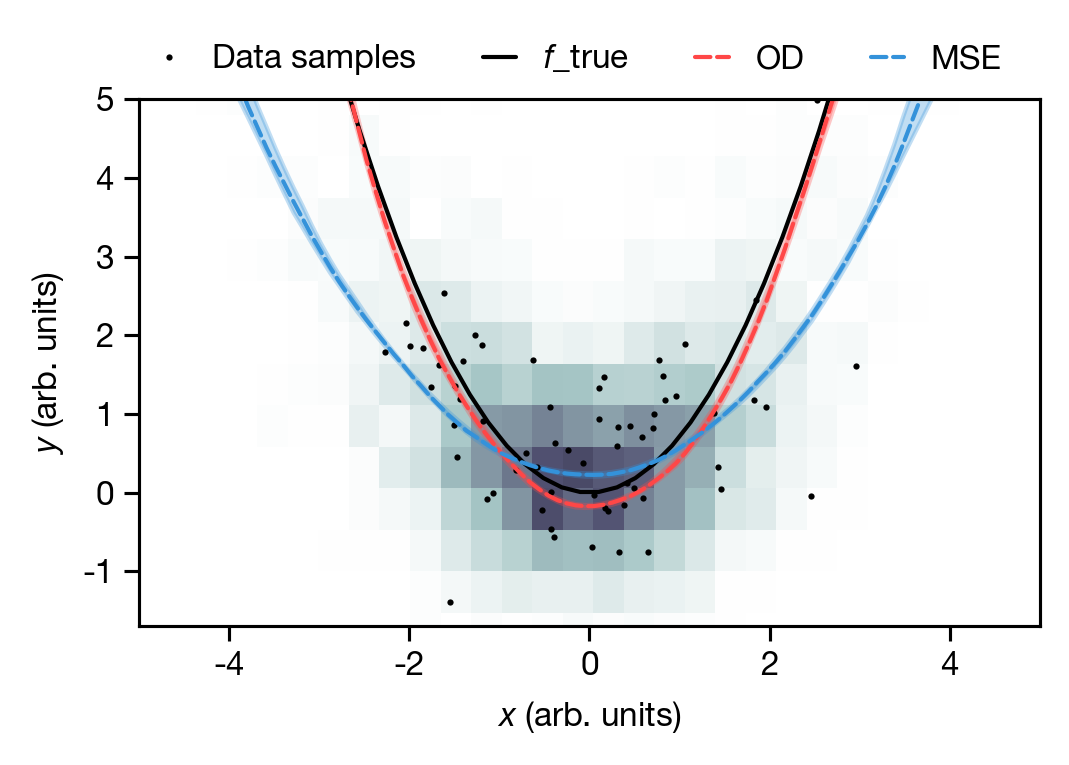

In [57]:
from plot_style.style_prab import figsize

f = lambda x : np.sqrt(0.5)*x**2


fig_w = figsize['inch']['column_width']

fig,ax = plt.subplots(1,1,figsize=(fig_w,fig_w*0.7))
x_lin = np.linspace(-5,5)

ax.hist2d(trainset.x.detach().flatten().numpy(),trainset.y.detach().flatten().numpy(),cmap='bone_r',bins=25,vmax=200)
ax.plot(testset.x.detach().flatten().numpy()[::8],testset.y.detach().flatten().numpy()[::8],'.',color='k',ms=3.,mew=0,label='Data samples')

ax.plot(x_lin,f(x_lin),color='k',label=r'$f$_true',lw=1.)
ax.fill_between(x.flatten(),q_OD_low.flatten(),q_OD_high.flatten(),color=colors_preset[0],lw=1.,alpha=0.3)
ax.fill_between(x.flatten(),q_MSE_low.flatten(),q_MSE_high.flatten(),color=colors_preset[3],lw=1.,alpha=0.3)
ax.plot(x,mean_OD,ls='--',color=colors_preset[0],label='OD',lw=1.)
ax.plot(x,mean_MSE,ls = '--',color=colors_preset[3],label='MSE',lw=1.)


k_ols = np.polyfit(trainset.x.flatten(),trainset.y.flatten(),2)


#ax.plot(x_lin,k_ols[0]*x_lin**2+k_ols[1]*x_lin+k_ols[2],'-o',color='gray',label='OLS',lw=0.3,ms=1.)
#ax.plot(x_lin,k_odr[0]*x_lin**2+k_odr[1]*x_lin+k_odr[2],'-s',color='gray',label='ODR',lw=0.3,ms=1)


ax.set_xlim(-5,5)
ax.set_ylim(-1.7,5.)
ax.set_xlabel(r'$x$ (arb. units)')
ax.set_ylabel('$y$ (arb. units)')

ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
          #mode="expand", 
          borderaxespad=0, 
          ncol=4,
          frameon=False,
          handlelength=1)

plt.savefig('figures/toy_problem_68,2.png')